### Training Steps

So far, we focused on logistic regression and SVM. Also we analyzed some vector embeddings with Word2Vec or similar methods.

Now, we are starting to use some State of the art language models based on neural networks and transformers.

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a state-of-the-art model in the field of natural language processing (NLP). Developed by researchers at Google, BERT has significantly advanced the capabilities of NLP models, enabling them to better understand the context of words in a sentence.

##### Key Features of BERT:

**Bidirectional Context Understanding**: Unlike traditional models that read text either left-to-right or right-to-left, BERT reads text in both directions simultaneously. This bidirectional approach allows BERT to understand the context of a word based on its surroundings, leading to more accurate interpretations of meaning.

**Transformer Architecture**: BERT is based on the Transformer architecture, which utilizes self-attention mechanisms to process input data. This architecture allows BERT to weigh the importance of different words in a sentence dynamically, enhancing its understanding of complex linguistic structures.

**Pre-training**: BERT is initially trained on a large corpus of text using two unsupervised tasks:
Masked Language Modeling (MLM): In this task, random words in a sentence are masked, and the model learns to predict the masked words based on the context provided by the surrounding words.
Next Sentence Prediction (NSP): This task involves predicting whether a given sentence follows another sentence, helping the model understand relationships between sentences.

**Fine-tuning**: After pre-training, BERT can be fine-tuned on specific tasks such as question answering, sentiment analysis, or named entity recognition by adding a small layer on top of the pre-trained model and training it on task-specific data.

**Transfer Learning**: BERT's pre-trained models can be fine-tuned on a wide range of NLP tasks with relatively small task-specific datasets. This transfer learning capability has made BERT highly versatile and effective across various applications.

For more information, go to [paper](https://arxiv.org/abs/1810.04805)

Let's start to investigate our models step by step.

#### Baseline

This is our first model without doing anything fancy. We have used 'bert-base-uncased' tokenizer. 

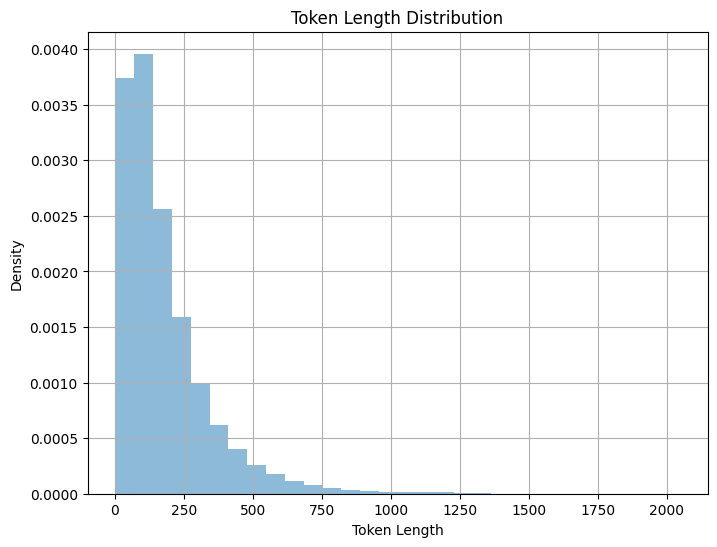

In [7]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
train_dataset["token_lengths"].hist(bins=30, density=True, alpha=0.5)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Density")
plt.show()

In [ ]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_sharing_strategy('file_system')
    # Your code here


random_seed = 42
torch.manual_seed(random_seed)

# Load the dataset
dataset = load_dataset("yelp_review_full")

# Create a custom dataset class
class YelpDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]["text"]
        label = self.data[index]["label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "token_type_ids": encoding["token_type_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and data loader
train_dataset = YelpDataset(dataset["train"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)

# Calculate the size of each part
num_parts = 5
part_size = len(train_dataset) // num_parts

# Process and save each part separately
for i in range(num_parts):
    print(f"Processing Part {i + 1}")
    
    # Define the start and end indices for the current part
    start_index = i * part_size
    end_index = start_index + part_size if i < num_parts - 1 else len(train_dataset)
    
    # Create a subset of the dataset for the current part
    part_dataset = torch.utils.data.Subset(train_dataset, list(range(start_index, end_index)))
    
    # Create a data loader for the current part
    part_loader = DataLoader(part_dataset, batch_size=32, shuffle=True, num_workers=8)
    
    # Process and save the data for the current part
    part_data = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "labels": []
    }

    for batch in tqdm(part_loader, desc=f"Processing Part {i + 1}"):
        part_data["input_ids"].append(batch["input_ids"])
        part_data["token_type_ids"].append(batch["token_type_ids"])
        part_data["attention_mask"].append(batch["attention_mask"])
        part_data["labels"].append(batch["labels"])

    # Convert to tensors
    part_data["input_ids"] = torch.cat(part_data["input_ids"], dim=0)
    part_data["token_type_ids"] = torch.cat(part_data["token_type_ids"], dim=0)
    part_data["attention_mask"] = torch.cat(part_data["attention_mask"], dim=0)
    part_data["labels"] = torch.cat(part_data["labels"], dim=0)

    # Save the data for the current part
    torch.save(part_data, f"yelp_data_part_{i + 1}.pt")

**As you may assume tokenization is a long process so we tokenized the dataset and saved it to files in order to use further models. This is our code to tokenize texts. There is no preprocessing at this step.
You can find the tokenizer code on parallel_tokenizer.py and parallel_tokenizer_preprocessing.py files.**

Now, we can start to build our model and training pipeline.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define the dataset class
class YelpDataset(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


Load the training data

In [ ]:
def load_data(is_test=False):
    # Load each part of the dataset
    data_parts = []
    for i in range(1, 6):
        if not is_test:
            part_data = torch.load(f'yelp_data_part_{i}.pt')
        if is_test:
            part_data = torch.load(f'test_yelp_data_part_{i}.pt')
        data_parts.append(part_data)
    return data_parts

data_parts = load_data()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
full_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [ ]:
data_parts = load_data(is_test=True)
test_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [ ]:
from sklearn.model_selection import train_test_split


# Use train_test_split to split the dataset into training, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = (len(full_dataset) - train_size)

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

As the base model, we have used BertForSequenceClassification. We attached 1 Layer classificaiton head to the BERT. After quick runs and the research on the available BERT models on the spaces, we decided to start with 4 epochs, 32 batch size and 2e-4 learning rate with 0.1 dropout rate.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
# Fine-tune BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
# Freeze BERT parameters
for param in model.bert.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Specify hyperparameters
epochs = 4
learning_rate = 2e-4
warmup_steps = 3

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
%%capture outs2
# Testing loop with tqdm
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')
with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.3043114977590549, Training Accuracy: 0.4369256645881195
Validation Loss: 1.1805259633193335, Validation Accuracy: 0.49444820374015747
Epoch 2/4
Training Loss: 1.2206021236350926, Training Accuracy: 0.4693243354118805
Validation Loss: 1.1485856288061367, Validation Accuracy: 0.504767470472441
Epoch 3/4
Training Loss: 1.207259475223059, Training Accuracy: 0.4743258396236736
Validation Loss: 1.13826560375728, Validation Accuracy: 0.5091043307086615
Epoch 4/4
Training Loss: 1.2029538757560316, Training Accuracy: 0.47701290887211467
Validation Loss: 1.13498492970124, Validation Accuracy: 0.509765625


In [ ]:
outs2()

Average Testing Loss: 1.1312, Average Testing Accuracy: 0.5126


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [14:34<00:00,  1.79it/s, Testing Loss=1.13, Testing Accuracy=0.513]   


This model is our baseline. In the following cells, we won't write te code again and again. You can find all the training steps and related notebook in Github repository. From now on, we will just show the changes and results.


#### Adding Preprocessing (All preprocessing steps are applied)

Upon the baseline this notebook explores if a preprocessing scheme with lemmatization leads to better predictions. The final accuracy drops to %46 from %50 due to the information loss in the lemmatization process, as expected.

Note that this is the same reason why we encounter terrible results in the linear models, in the previous notebook. We showed that some preprocessing operations can lead worse results in some data characteristics.

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.393277020752267, Training Accuracy: 0.3917548681763483
Validation Loss: 1.283207580095201, Validation Accuracy: 0.44895730807086615
Epoch 2/4
Training Loss: 1.327565246139701, Training Accuracy: 0.42273308445465485
Validation Loss: 1.2616023259956066, Validation Accuracy: 0.4568467027559055
Epoch 3/4
Training Loss: 1.3164710248276932, Training Accuracy: 0.42795851110381794
Validation Loss: 1.2477558573751937, Validation Accuracy: 0.46315206692913385
Epoch 4/4
Training Loss: 1.31130342439637, Training Accuracy: 0.4303943086095613
Validation Loss: 1.2446318346801706, Validation Accuracy: 0.4646438238188976


In [ ]:
outs2()

Average Testing Loss: 1.2431, Average Testing Accuracy: 0.4626


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [14:34<00:00,  1.79it/s, Testing Loss=1.24, Testing Accuracy=0.463]   


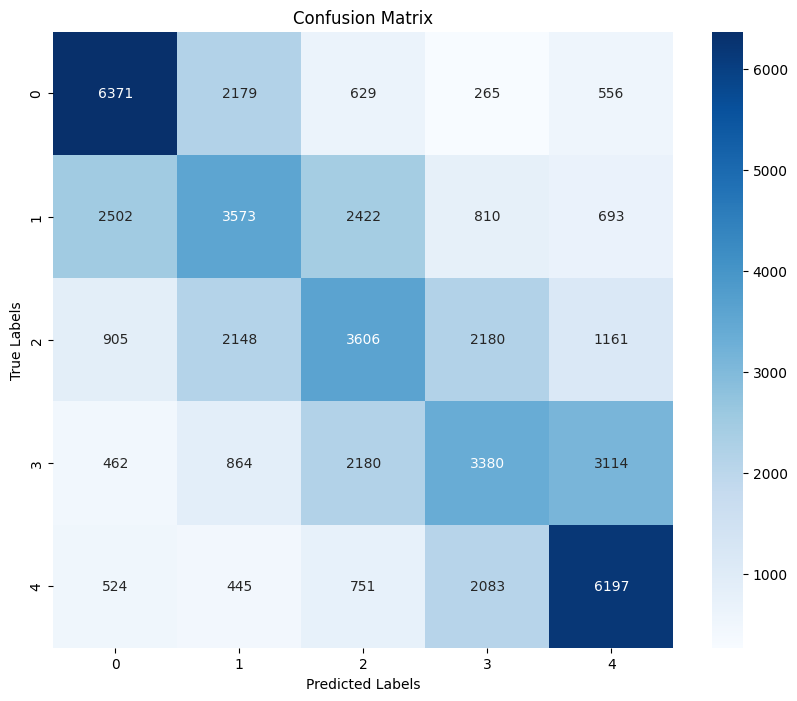

In [ ]:
#### Confusion Matrix ####

#### Adding Preprocessing (Final Preprocessing Function)

Considering the information loss due to the lemmatization, we did the pre-processing without lemmatization and we fixed the non-encoded characters, unnecessary quotation marks, handled special white-space characters, handled punctuations and dots (details can be found in parallel_tokenizer.py). We reached the baseline accuracy again with this setup.

In the preprocessing notebook, you can find the preprocessing function.

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.3425457976100716, Training Accuracy: 0.41724783940487914
Validation Loss: 1.22359186578102, Validation Accuracy: 0.4773929625984252
Epoch 2/4
Training Loss: 1.2649315931860667, Training Accuracy: 0.450275544251176
Validation Loss: 1.1996696840707712, Validation Accuracy: 0.48016117125984253
Epoch 3/4
Training Loss: 1.252322158766137, Training Accuracy: 0.4556479734164752
Validation Loss: 1.1773216591517286, Validation Accuracy: 0.49617064468503935
Epoch 4/4
Training Loss: 1.2483002736621658, Training Accuracy: 0.45859657039711194
Validation Loss: 1.1759931677439082, Validation Accuracy: 0.495847687007874


In [ ]:
outs2()

Average Testing Loss: 1.1737, Average Testing Accuracy: 0.4936


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [28:05<00:00,  1.08s/it, Testing Loss=1.17, Testing Accuracy=0.494]   


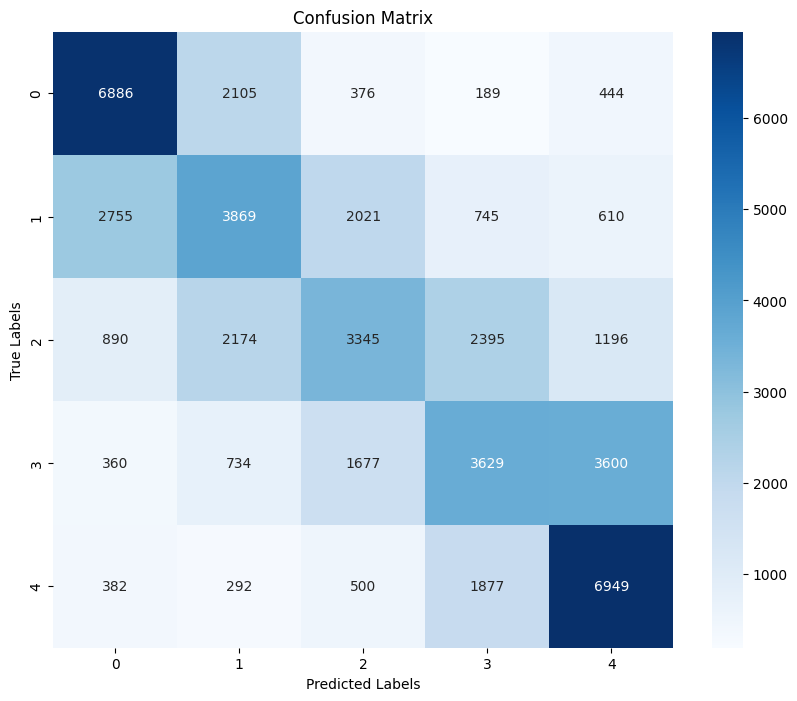

In [ ]:
### Confusion Matrix ###

### Classification with 2 Layer

We have increased the number of layers in the classification layer to capture more complex relations. Resulted in a minor increase in the final accuracy. However, 4 epochs was under-training for this case because there is a gap between train and validation accuracy.

In [ ]:
# Define the new classifier layers
import torch.nn as nn
from transformers import BertForSequenceClassification, BertConfig
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 128),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(128, 5)
)
# Replace the classifier of the pre-trained model
model.classifier = classifier

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.2775801845565955, Training Accuracy: 0.4382103136015559
Validation Loss: 1.1604789357292256, Validation Accuracy: 0.498428102788409
Epoch 2/4
Training Loss: 1.2449781643282212, Training Accuracy: 0.4560460222438313
Validation Loss: 1.1491254234392179, Validation Accuracy: 0.5034513395297977
Epoch 3/4
Training Loss: 1.2380107360476202, Training Accuracy: 0.4590088276406953
Validation Loss: 1.160428573943149, Validation Accuracy: 0.4959164844177146
Epoch 4/4
Training Loss: 1.2326196374262293, Training Accuracy: 0.46207039321745474
Validation Loss: 1.1375419220486387, Validation Accuracy: 0.5091580098414434


In [ ]:
outs2()

Average Testing Loss: 1.1350, Average Testing Accuracy: 0.5074


Epoch 4/4 (Testing): 100%|##########| 1407/1407 [13:24<00:00,  1.75it/s, Testing Loss=1.13, Testing Accuracy=0.507]    


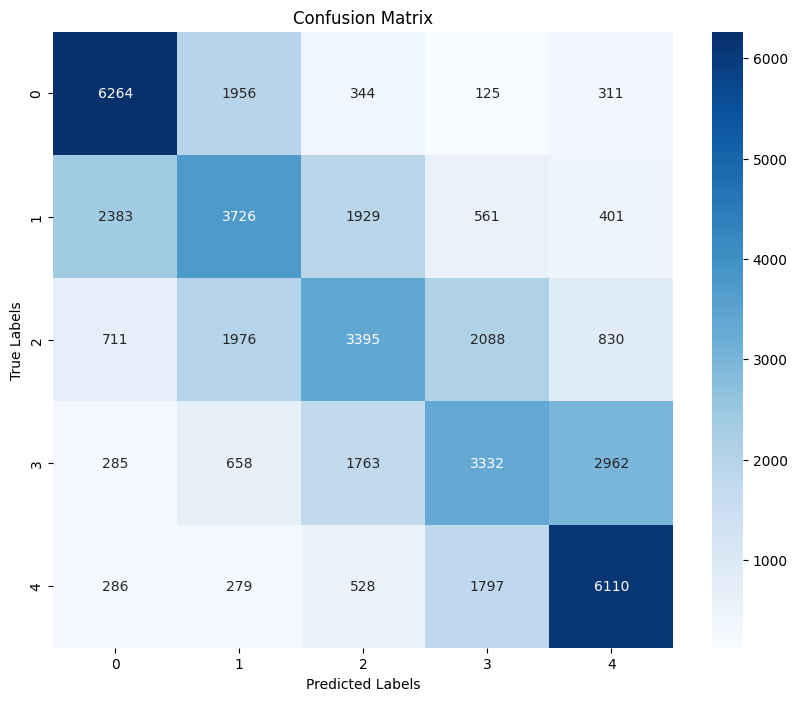

In [ ]:
### Confusion Matrix ###

We have reached better results with 2 Layer Classifier. However, we suspect undertraining because of the gap between validation and test accuracy.

### Starting training experiments with subset

We switched to training with subset instead of the whole to reduce the training times in order to do more compherensive HPO. This is a baseline for smaller subset.

There is no much code here but assume that ,until the final architecture and training, we will use 0.1 of the training set.

### Classification with 3 Layer

Increased the classification layers to three, to increase the model's complexity to handle more complex relations. Not much of a difference is observed. 

In [ ]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 1.368411942184004, Training Accuracy: 0.3913340623291416
Validation Loss: 1.2072524469272763, Validation Accuracy: 0.4777879901960784
Epoch 2/4
Training Loss: 1.2752008379450779, Training Accuracy: 0.4421473482777474
Validation Loss: 1.1702535342352063, Validation Accuracy: 0.48483455882352944
Epoch 3/4
Training Loss: 1.2606634629300673, Training Accuracy: 0.44800779114270095
Validation Loss: 1.1569969595647325, Validation Accuracy: 0.49984681372549017
Epoch 4/4
Training Loss: 1.2472437312526088, Training Accuracy: 0.4557989338436304
Validation Loss: 1.1497672223577313, Validation Accuracy: 0.49846813725490197


In [ ]:
outs2()

Average Testing Loss: 1.1688, Average Testing Accuracy: 0.4867


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:31<00:00,  1.72it/s, Testing Loss=1.17, Testing Accuracy=0.487]   


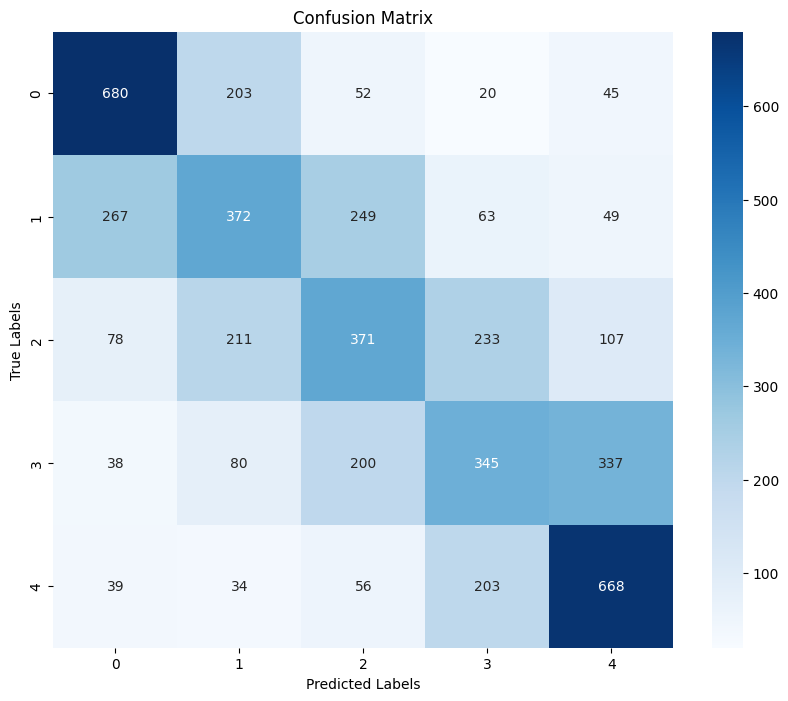

In [ ]:
### Confusion Matrix ###

At this point, we decided that original embedding space of the bert model does not align with our task and we decided to see the results with the finetuned embedding space as well.

### Classification wtih 2 Layer and All Unfreeze

With the frozen embedding space we couldn't get promising results so we decided to finetune the embedding space with lower learning rates. As expected, the results are overfitted a little. It could perform better with the whole dataset in terms of overfitting.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

# Create separate parameter groups for BERT and classifier
bert_params = []
classifier_params = []
for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    else:
        bert_params.append(param)

# Set up the optimizer with different learning rates for BERT and classifier
optimizer_grouped_parameters = [
    {'params': bert_params, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9391978535579162, Training Accuracy: 0.5826100328048114
Validation Loss: 0.8333215283996919, Validation Accuracy: 0.6393995098039216
Epoch 2/4
Training Loss: 0.7756779108007076, Training Accuracy: 0.6597696828868234
Validation Loss: 0.8073050945120699, Validation Accuracy: 0.6527267156862745
Epoch 3/4
Training Loss: 0.6898153159643146, Training Accuracy: 0.7028601694915254
Validation Loss: 0.8087778219989702, Validation Accuracy: 0.6588541666666666
Epoch 4/4
Training Loss: 0.6250813028863247, Training Accuracy: 0.7349302897758337
Validation Loss: 0.8309259507439885, Validation Accuracy: 0.6602328431372549


In [ ]:
outs2()

Average Testing Loss: 0.8595, Average Testing Accuracy: 0.6453


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:28<00:00,  1.77it/s, Testing Loss=0.86, Testing Accuracy=0.645]   


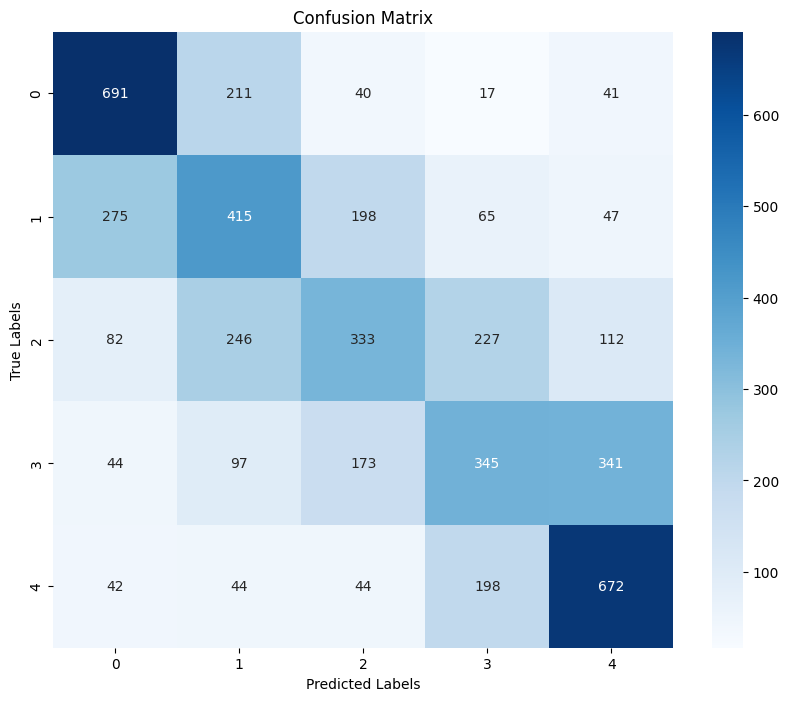

In [ ]:
### Confusion Matrix ###

As you can see, we achieved way better results. Our embedding space is also trained. This enables model to learn more about our documents.

### Classification with 2 Layer and 6 Layer Unfreeze

Only the last 6 layers of the BertEncoder is unfreezen as suggested in the papers and used as a SOTA way for finetuning BERT models on downstream tasks. BertEncoders are updated with lower learning rate compared to the classification head. Reached the same accuracy with the AllUnfreeze model with less overfitting.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9703559463078888, Training Accuracy: 0.5705303444505194
Validation Loss: 0.8632782574962167, Validation Accuracy: 0.6173406862745098
Epoch 2/4
Training Loss: 0.8469399492423869, Training Accuracy: 0.6279558501913614
Validation Loss: 0.8296068944036961, Validation Accuracy: 0.6331188725490197
Epoch 3/4
Training Loss: 0.7921296302381925, Training Accuracy: 0.6538408966648441
Validation Loss: 0.813924707034055, Validation Accuracy: 0.6430759803921569
Epoch 4/4
Training Loss: 0.7553609741750866, Training Accuracy: 0.6699699289229087
Validation Loss: 0.8131635712057936, Validation Accuracy: 0.6429227941176471


In [ ]:
outs2()

Average Testing Loss: 0.8275, Average Testing Accuracy: 0.6407


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:29<00:00,  1.76it/s, Testing Loss=0.827, Testing Accuracy=0.641]  


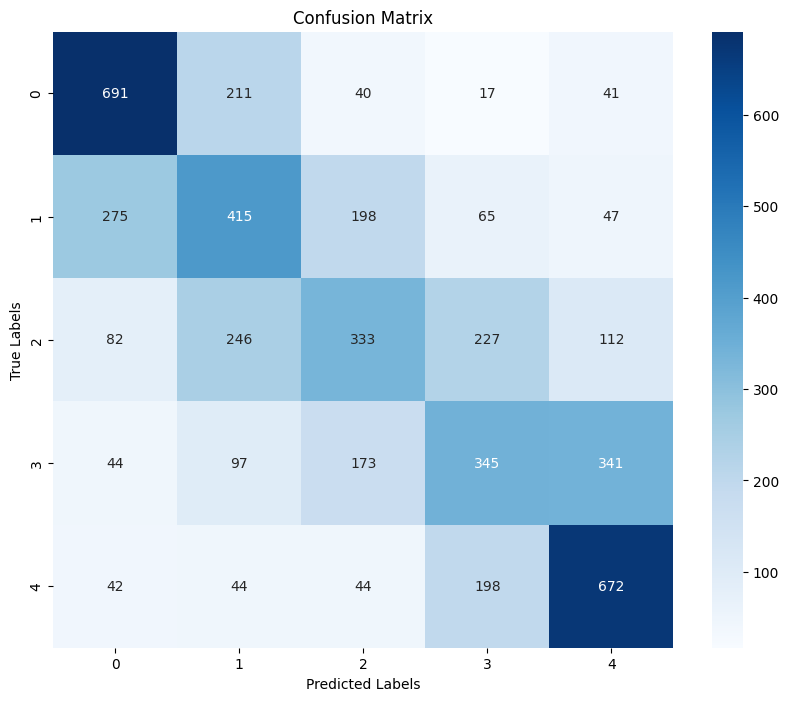

In [ ]:
### Confusion Matrix ###

### Classification with 3 Layer and 6 Layer Unfreeze

Upon the good results of the 2 Layer 6 Unfreeze model, we would like to see the extension to the third layer. But we couldn't observe any improvements in the subset. We concluded that the subset was not adequate to train all the parameters, and to be on the safe side we decided to continue with 3 layer architecture.

In [ ]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9900317240634728, Training Accuracy: 0.5634568069983598
Validation Loss: 0.8989464126381219, Validation Accuracy: 0.6047794117647058
Epoch 2/4
Training Loss: 0.8563629415368955, Training Accuracy: 0.6257517769272827
Validation Loss: 0.8357810741838287, Validation Accuracy: 0.6349571078431373
Epoch 3/4
Training Loss: 0.8050422369944977, Training Accuracy: 0.6465794149808639
Validation Loss: 0.823057827777138, Validation Accuracy: 0.6421568627450981
Epoch 4/4
Training Loss: 0.7660877910091813, Training Accuracy: 0.6656642974302898
Validation Loss: 0.8166496235073781, Validation Accuracy: 0.6482843137254902


In [ ]:
outs2()

Average Testing Loss: 0.8309, Average Testing Accuracy: 0.6397


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.831, Testing Accuracy=0.64]   


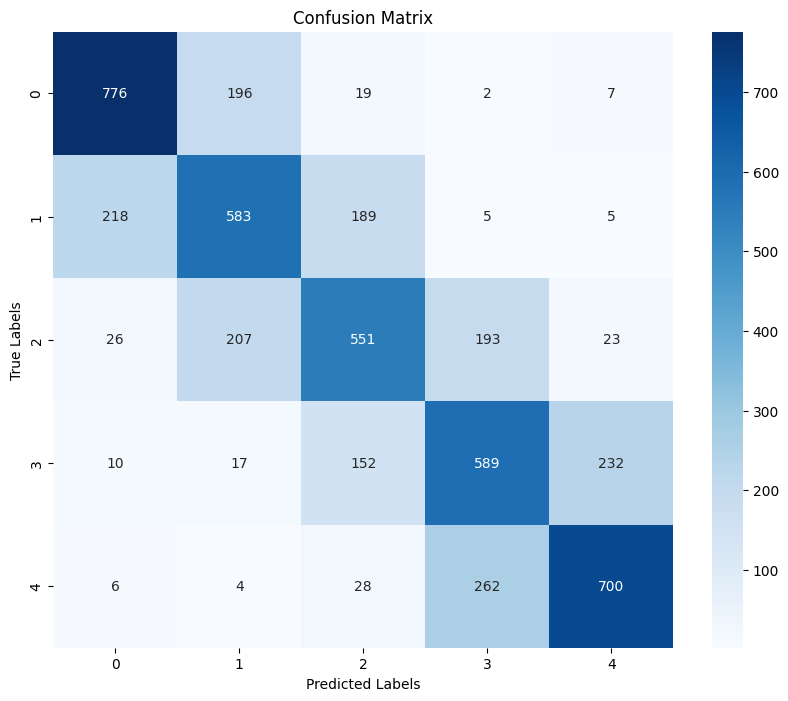

In [ ]:
### Confusion Matrix ###

### Regression and Effect of Ordinality

Upon to the last experiment, we wanted to see the effect of ordinality. Because, in the previous ones we treated classes as unordinary due to the softmax. Now, we want to preserve the ordinality with sigmoid activation function.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Define the model architecture for regression
class BERTRegression(torch.nn.Module):
    def __init__(self):
        super(BERTRegression, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier1 = torch.nn.Linear(768, 256)
        self.classifier2 = torch.nn.Linear(256, 64)
        self.classifier3 = torch.nn.Linear(64, 1)
        self.activate = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(0.1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        x1 = self.classifier1(pooler)
        x1_a = self.activate(x1)
        x1_drop = self.dropout(x1_a)
        x2 = self.classifier2(x1_drop)
        x2_a = self.activate(x2)
        x2_drop = self.dropout(x2_a)
        x3 = self.classifier3(x2_drop)
        out = self.sigmoid(x3)
        return out

model = BERTRegression()
criterion = nn.MSELoss()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.03446603013292167, Training Accuracy: 0.5513087752870421
Validation Loss: 0.02833527836528625, Validation Accuracy: 0.5962009803921569
Epoch 2/4
Training Loss: 0.027248807966876155, Training Accuracy: 0.6035231000546747
Validation Loss: 0.02779806455752502, Validation Accuracy: 0.6049325980392157
Epoch 3/4
Training Loss: 0.02401820649767163, Training Accuracy: 0.6270844723892838
Validation Loss: 0.025581075376191854, Validation Accuracy: 0.6352634803921569
Epoch 4/4
Training Loss: 0.02219760639770206, Training Accuracy: 0.6400697102241663
Validation Loss: 0.025147881491255818, Validation Accuracy: 0.6367953431372549


In [ ]:
outs2()

Average Testing Loss: 0.0254, Average Testing Accuracy: 0.6254


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0254, Testing Accuracy=0.625]  


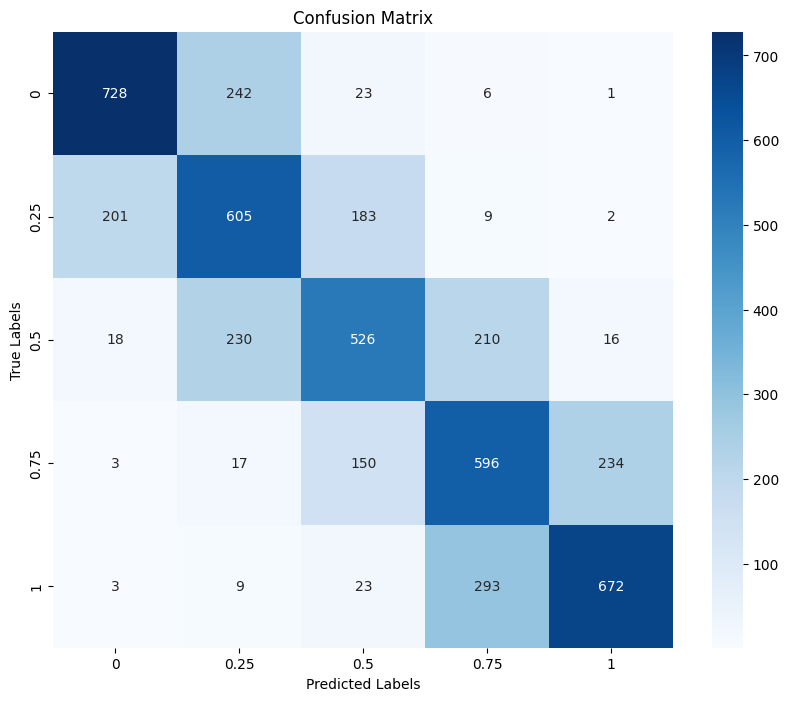

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Original labels and predictions
# all_labels and all_predictions should be defined elsewhere in your code

# Define the mapping
mapping = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}

# Function to map values to integers
def map_to_int(values, mapping):
    return np.array([mapping[v] for v in values])

# Map the labels and predictions
all_labels_mapped = map_to_int(all_labels, mapping)
all_predictions_mapped = map_to_int(all_predictions, mapping)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_mapped, all_predictions_mapped)

# Define class names for the heatmap
class_names = ['0', '0.25', '0.5', '0.75', '1']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Regression + Leaky Relu

We switched to the LeakyRelu activation function instead of tanh, to observe possible theoretical advantages of it. However, there is not much of a difference.

In [ ]:
self.activate = torch.nn.LeakyReLU()

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.02111507493400709, Training Accuracy: 0.6463572990705303
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 2/4
Training Loss: 0.021097260101623487, Training Accuracy: 0.6490226899945325
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 3/4
Training Loss: 0.02101718099225677, Training Accuracy: 0.6454346637506835
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 4/4
Training Loss: 0.02104165478206727, Training Accuracy: 0.6470919901585566
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863


In [ ]:
outs2()

Average Testing Loss: 0.0253, Average Testing Accuracy: 0.6180


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0253, Testing Accuracy=0.618]  


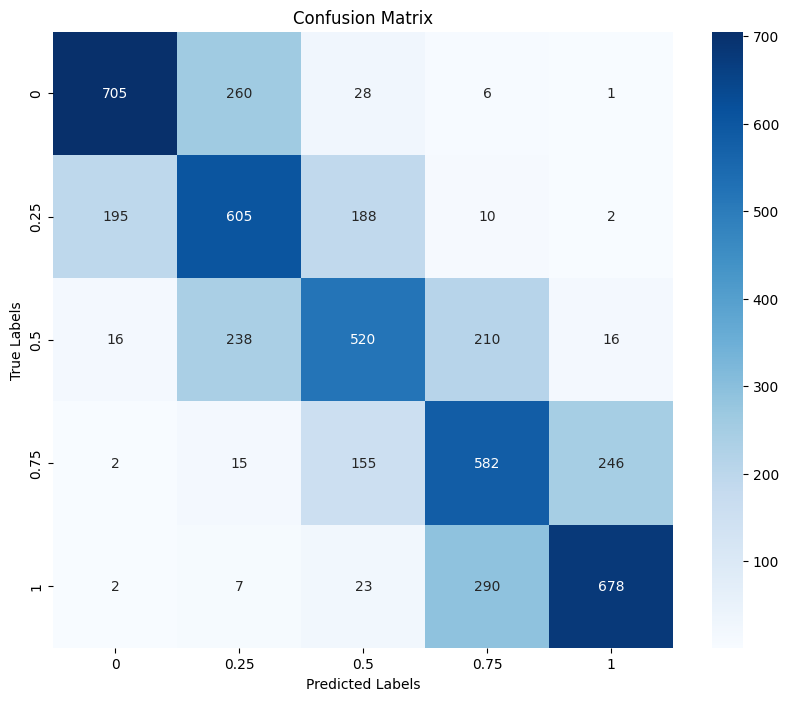

In [ ]:
### Confusion Matrix ###

In [35]:
from scipy.optimize import differential_evolution
import numpy as np
from sklearn.metrics import accuracy_score

# Function to calculate accuracy for given thresholds
def calculate_accuracy(predictions, labels, thresholds):
    class_preds = np.digitize(predictions, thresholds)
    return accuracy_score(labels, class_preds)

# Convert back to original scale
labels = np.array(all_labels) * 4

# Define the objective function for optimization
def objective(thresholds):
    thresholds = np.sort(thresholds)  # Ensure thresholds are sorted
    return -calculate_accuracy(all_raw_predictions, labels, thresholds)  # We minimize, so negate accuracy

# Define bounds for the thresholds (three thresholds between 0 and 1)
bounds = [(0, 1), (0, 1), (0, 1), (0,1)]

class TqdmProgress:
    def __init__(self, max_iter):
        self.progress_bar = tqdm(total=max_iter, desc="Optimization Progress", position=0, leave=True)
        self.iteration = 0

    def __call__(self, xk, convergence):
        self.iteration += 1
        self.progress_bar.update(1)

    def close(self):
        self.progress_bar.close()

# Initialize the progress bar
progress = TqdmProgress(50000)

# Perform differential evolution to find the optimal thresholds
result = differential_evolution(
    objective, 
    bounds, 
    maxiter=50000,      
    popsize=500,          
    mutation=(0.5, 1),     
    recombination=0.5,     
    callback=progress       
)

# Close the progress bar
progress.close()
# Get the best thresholds and accuracy
best_thresholds = np.sort(result.x)
best_accuracy = -result.fun

print(f'Best Accuracy: {best_accuracy:.4f} with thresholds: {best_thresholds}')

Optimization Progress:   0%|                                          | 36/50000 [01:20<31:02:13,  2.24s/it]

Best Accuracy: 0.6284 with thresholds: [0.12495491 0.38662843 0.63670718 0.82971599]


### Attention Mechanism

We wanted to switch the LeakyRelu with GELU activation function and wanted to add attention layers to better handle the padding tokens.

The attention mechanism is a concept within neural networks that allows the model to focus on specific parts of the input sequence when making predictions. It was originally introduced to improve performance in sequence-to-sequence models, particularly in the field of machine translation. The key idea is to dynamically weigh the importance of different elements in the input sequence, allowing the model to concentrate on relevant parts of the data while ignoring less relevant parts.

* Improved Performance: Attention mechanisms can significantly enhance the performance of neural networks on tasks involving sequential data, such as machine translation, text summarization, and question answering, by allowing the model to focus on relevant parts of the input.

* Handling Long Sequences: Traditional sequence models like RNNs and LSTMs struggle with long dependencies due to issues like vanishing gradients. Attention mechanisms, particularly self-attention, can handle long sequences more effectively by providing direct connections between distant elements of the sequence.

* Parallelization: In the Transformer architecture, the use of self-attention allows for more parallel computation compared to RNNs, which process sequences sequentially. This leads to faster training times and more efficient use of computational resources.

* Interpretability: Attention weights can provide insights into what parts of the input the model is focusing on. This can help in understanding the model's decisions and improving interpretability.

* Flexibility: Attention mechanisms can be easily adapted to various tasks and architectures. They are not limited to text data and have been successfully applied in areas like image captioning and speech recognition.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
from transformers import modeling_outputs
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
classifier_params = []

for name, param in model.named_parameters():
    if name.startswith('bert.embeddings') or (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 7):
        param.requires_grad = False
    if (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) >= 7):
        bert_params_last_6.append(param)
    if ((name.startswith('classifier')) or (name.startswith('bert.pooler')) or (name.startswith('attention')) or (name.startswith('layer_norm'))):
        classifier_params.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.9687884016855615, Training Accuracy: 0.5754852378348825
Validation Loss: 0.8841111110705956, Validation Accuracy: 0.6128982843137255
Epoch 2/4
Training Loss: 0.8557966662241893, Training Accuracy: 0.6248633132859486
Validation Loss: 0.8552585698518098, Validation Accuracy: 0.6289828431372549
Epoch 3/4
Training Loss: 0.8110408217871756, Training Accuracy: 0.6468869600874795
Validation Loss: 0.828862644293729, Validation Accuracy: 0.6397058823529411
Epoch 4/4
Training Loss: 0.7733738182215433, Training Accuracy: 0.6618712411153636
Validation Loss: 0.8228677866213462, Validation Accuracy: 0.6389399509803921


In [ ]:
outs2()

Average Testing Loss: 0.8313, Average Testing Accuracy: 0.6346


Epoch 4/4 (Testing): 100%|##########| 157/157 [01:10<00:00,  2.24it/s, Testing Loss=0.831, Testing Accuracy=0.635]  


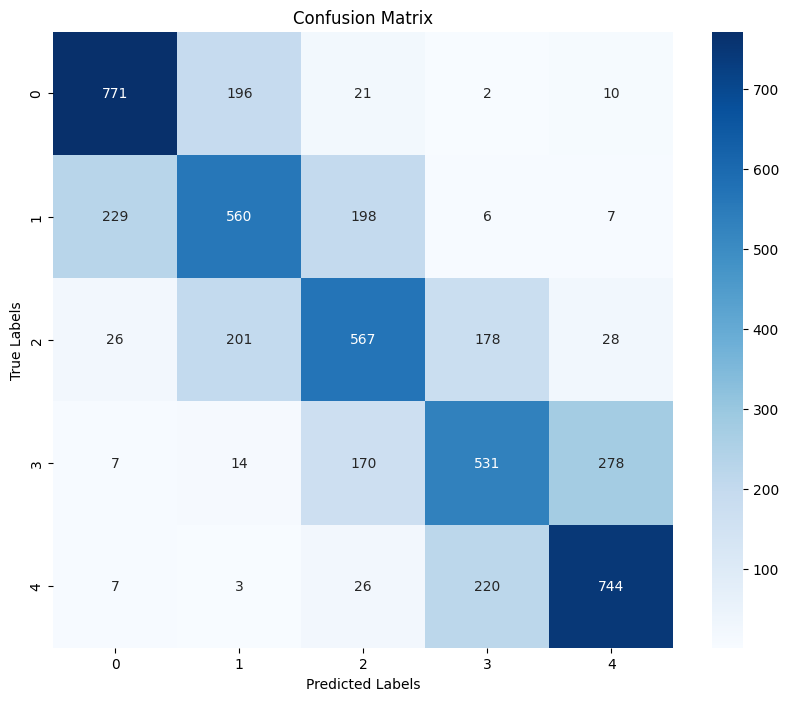

In [ ]:
### Confusion Matrix ###

### Train with All Data with Best 2 Architecture

We have 2 architecture giving accuracy around %64. We do not have that much of GPU power so we will train just these 2 models with all data. 

#### First Model

Since this model was the one of the bests, we trained this model with the whole dataset again.

In [ ]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
from transformers import modeling_outputs
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
classifier_params = []

for name, param in model.named_parameters():
    if name.startswith('bert.embeddings') or (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 7):
        param.requires_grad = False
    if (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) >= 7):
        bert_params_last_6.append(param)
    if ((name.startswith('classifier')) or (name.startswith('bert.pooler')) or (name.startswith('attention')) or (name.startswith('layer_norm'))):
        classifier_params.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


EnhancedBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.8226125934376731, Training Accuracy: 0.6392712093862816
Validation Loss: 0.7456464996986737, Validation Accuracy: 0.6694605068897638
Epoch 2/4
Training Loss: 0.7314922203512685, Training Accuracy: 0.6798490318345914
Validation Loss: 0.7173082605444305, Validation Accuracy: 0.68677718996063
Epoch 3/4
Training Loss: 0.6958607956530711, Training Accuracy: 0.6945561207745323
Validation Loss: 0.7028372092685831, Validation Accuracy: 0.6922828494094488
Epoch 4/4
Training Loss: 0.6739806418570292, Training Accuracy: 0.7043027294606717
Validation Loss: 0.7018289785157508, Validation Accuracy: 0.6927903543307087


In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs2()

Average Testing Loss: 0.7099, Average Testing Accuracy: 0.6890


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:50<00:00,  2.20it/s, Testing Loss=0.71, Testing Accuracy=0.689]   


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_14.pth')

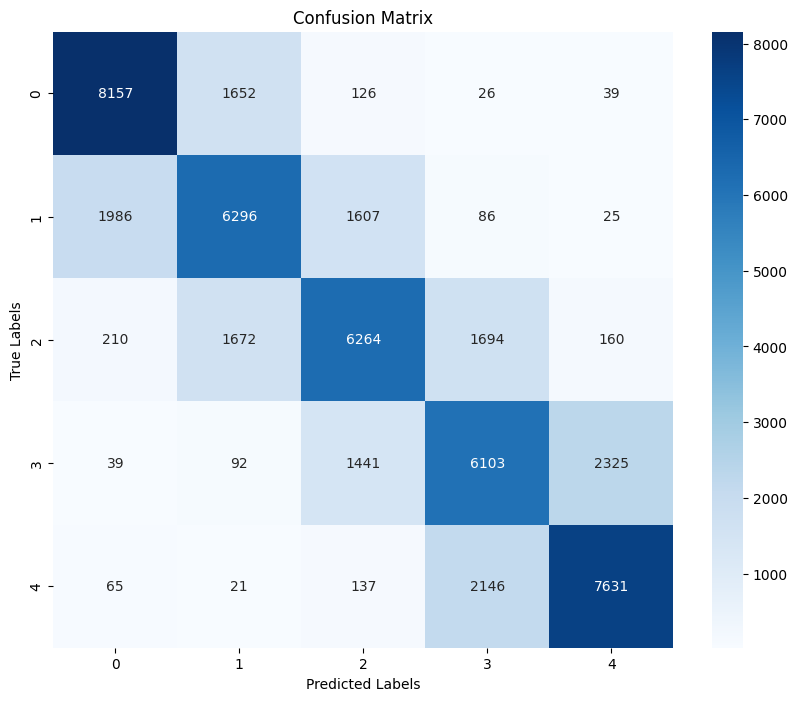

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Second Model

The whole dataset training of the other best model.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F

# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 5)
)

# Replace the classifier of the pre-trained model
model.classifier = classifier

# Update the number of labels in the config
model.config.num_labels = 5
model.num_labels = 5

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [ ]:
outs1()

In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [ ]:
outs2()

Average Testing Loss: 0.7109, Average Testing Accuracy: 0.6896


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:27<00:00,  2.27it/s, Testing Loss=0.711, Testing Accuracy=0.69]   


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_15.pth')

In [ ]:
outs1()

Epoch 1/4
Training Loss: 0.8272007566718483, Training Accuracy: 0.6369909610545892
Validation Loss: 0.7531800072962843, Validation Accuracy: 0.6714905265748031
Epoch 2/4
Training Loss: 0.7366962426976502, Training Accuracy: 0.6778456952193415
Validation Loss: 0.720752185547915, Validation Accuracy: 0.6872231791338582
Epoch 3/4
Training Loss: 0.7014354298965322, Training Accuracy: 0.6931749808554862
Validation Loss: 0.7115582478504012, Validation Accuracy: 0.6885765255905512
Epoch 4/4
Training Loss: 0.6780820782127741, Training Accuracy: 0.7034583196586807
Validation Loss: 0.7059024091457992, Validation Accuracy: 0.6927442175196851


In [ ]:
outs2()

Average Testing Loss: 0.7109, Average Testing Accuracy: 0.6896


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:27<00:00,  2.27it/s, Testing Loss=0.711, Testing Accuracy=0.69]   


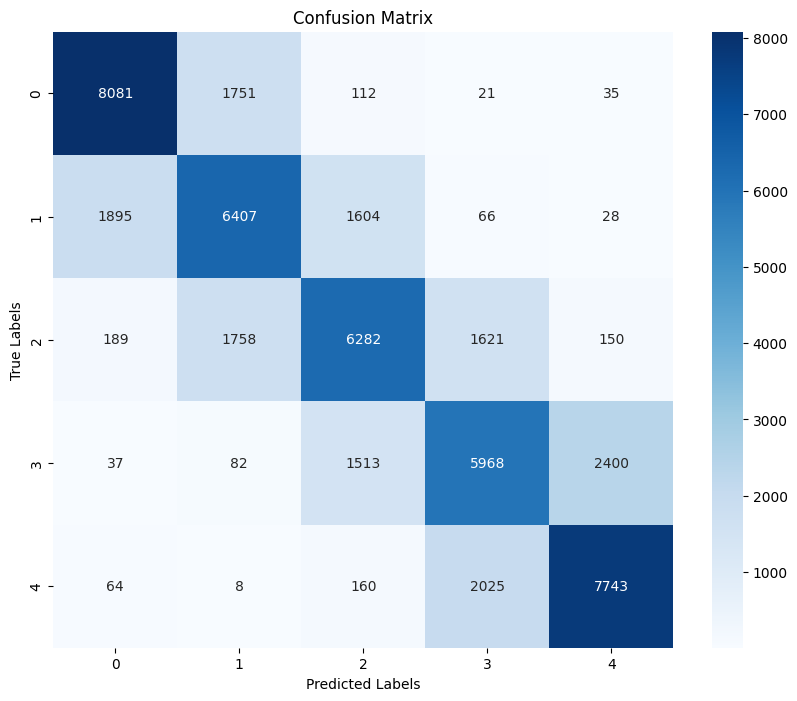

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_predictions)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     10000
           1       0.64      0.64      0.64     10000
           2       0.65      0.63      0.64     10000
           3       0.62      0.60      0.61     10000
           4       0.75      0.77      0.76     10000

    accuracy                           0.69     50000
   macro avg       0.69      0.69      0.69     50000
weighted avg       0.69      0.69      0.69     50000



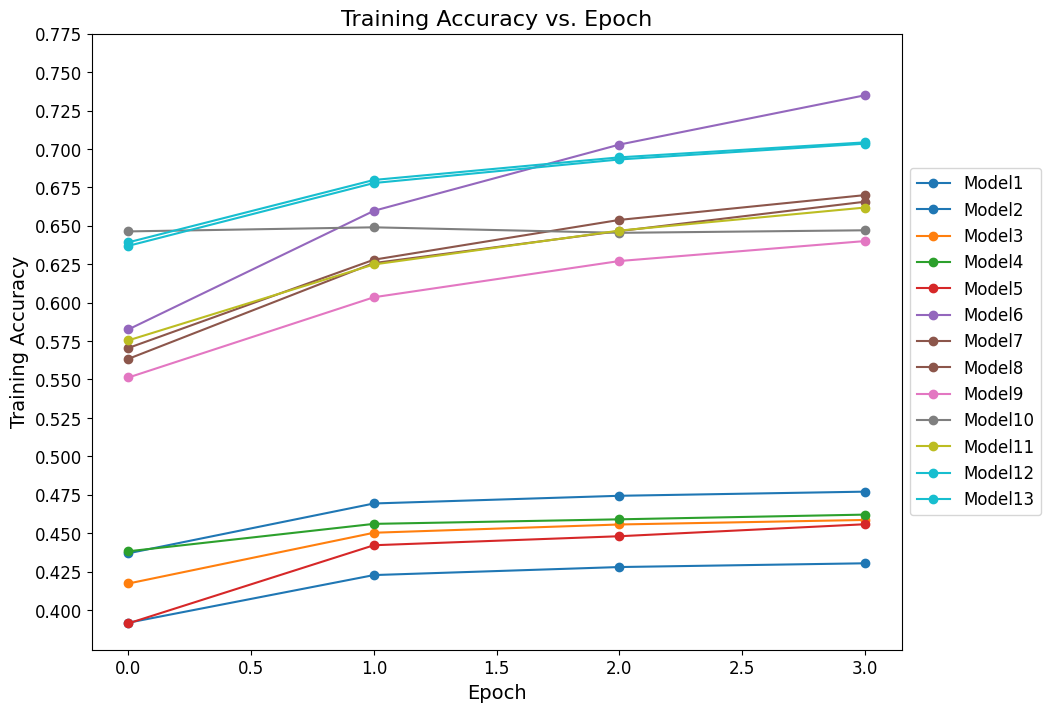

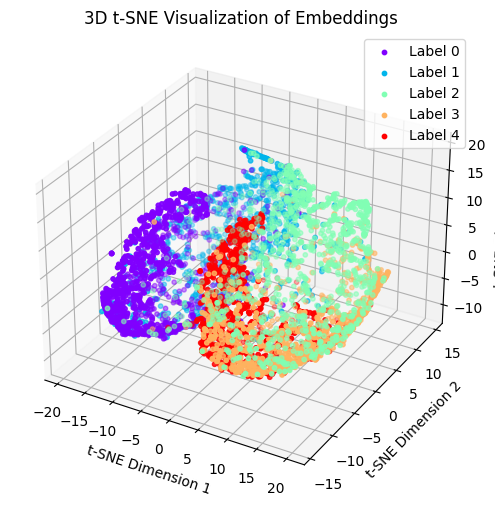

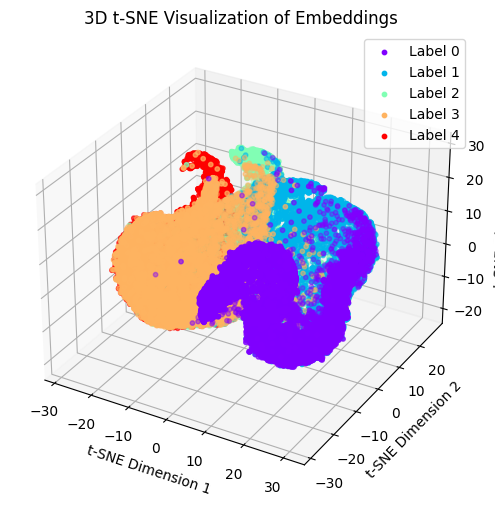

In [52]:
import numpy as np

# Assuming all_predictions and all_labels are numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate the element-wise Hamming distance
absolute_differences = np.abs(all_predictions - all_labels)

print(f"Hamming Distance of Wrong Predictions: {np.mean(absolute_differences[absolute_differences != 0]):.2f}")

Hamming Distance of Wrong Predictions: 1.08


In [12]:
outs2()

Average Testing Loss: 0.1278, Average Testing Accuracy: 0.9552


Epoch 4/4 (Testing): 100%|##########| 126/126 [00:55<00:00,  2.27it/s, Testing Loss=0.128, Testing Accuracy=0.955]  


### MODEL EVALUATION AND OTHER MODELS

YELP Review Dataset is widely known dataset so it is used in different models. As a result there are lots of models uploaded to huggingface. In this notebook we evaluate this models and our model in terms of accuracy, f1_score and similar metrics. Note that there is just one model in huggingface that gives better result than our models.

Install datasets library to use models.

In [ ]:
# install datasets
!pip install datasets

In [2]:
import json

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [12]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [13]:
train_dataset = dataset['train']
test_dataset = dataset['test']

We are GPU Poor :(

Because of tokenizers and inference, testing can be a bit long.

In [14]:
x_test = test_dataset['text'][:5000]
y_test = test_dataset['label'][:5000]

Using first 5000 sample is not much different than using 65k test set. All the models give similar result as they indicated in their huggingface model page.

In [57]:
import torch
# Function to perform sentiment analysis
def analyze_sentiment(text, tokenizer,model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class (logits)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Map predicted class to sentiment (assuming 0-4 corresponds to 1-5 star ratings)
    sentiment = predicted_class
    
    return sentiment

In [56]:
# Predict sentiments for the test set
def predict(x_test, tokenizer, model):
    y_pred = []
    for i,doc in enumerate(x_test):
        result = analyze_sentiment(doc,tokenizer, model)
        y_pred.append(result)
        print(i)
    return y_pred

In [122]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def metrics(y_test, y_pred, binary=False):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score: {f1:.2f}")

    # Generate a classification report
    report = classification_report(y_test, y_pred)
    print(f"Classification Report:\n{report}")
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 7))
    if not binary:
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    if binary:
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

#### Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews

This model is a fine-tuned version of distilbert-base-uncased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 0.8288
* Accuracy: 0.6418
* F1: 0.6425

The following hyperparameters were used during training:

* learning_rate: 2e-05
* train_batch_size: 32
* eval_batch_size: 32
* seed: 42
* optimizer: Adam with betas=(0.9,0.999) and epsilon=1e-08
* lr_scheduler_type: linear
* num_epochs: 2

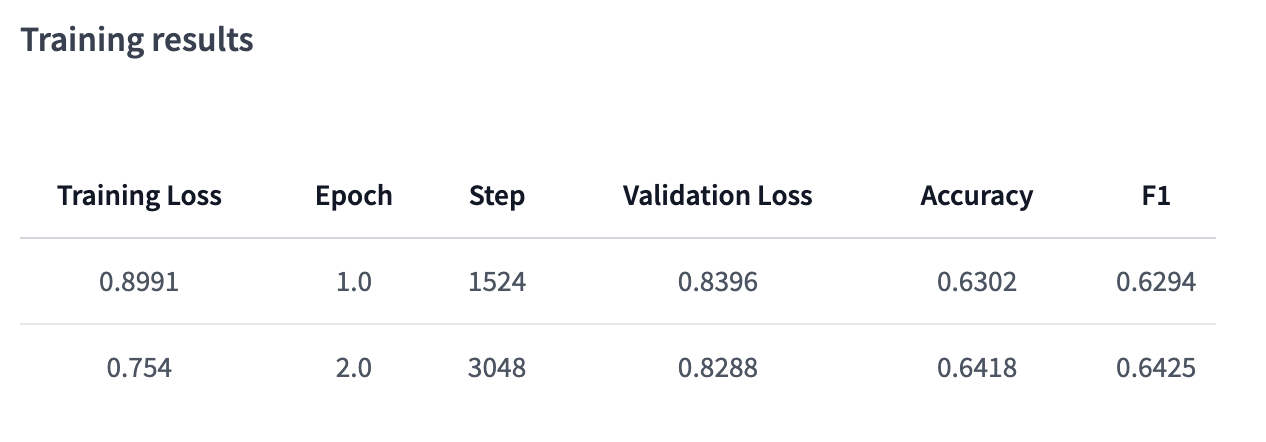

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_distilbert_base_uncased_finetuned_yelp_reviews = AutoTokenizer.from_pretrained("Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews")
model_distilbert_base_uncased_finetuned_yelp_reviews = AutoModelForSequenceClassification.from_pretrained("Ramamurthi/distilbert-base-uncased-finetuned-yelp-reviews")

In [ ]:
y_pred_distilbert_base_uncased_finetuned_yelp_reviews = predict(x_test, tokenizer_distilbert_base_uncased_finetuned_yelp_reviews, model_distilbert_base_uncased_finetuned_yelp_reviews)

In [ ]:
with open('y_pred_distilbert_base_uncased_finetuned_yelp_reviews.json', 'w') as f:
    json.dump(y_pred_distilbert_base_uncased_finetuned_yelp_reviews, f)

In [3]:
y_pred_distilbert_base_uncased_finetuned_yelp_reviews = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_distilbert_base_uncased_finetuned_yelp_reviews.json"))

Accuracy: 0.64
F1 Score: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1141
           1       0.57      0.58      0.58      1009
           2       0.59      0.55      0.57      1003
           3       0.58      0.56      0.57       986
           4       0.68      0.74      0.71       861

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000



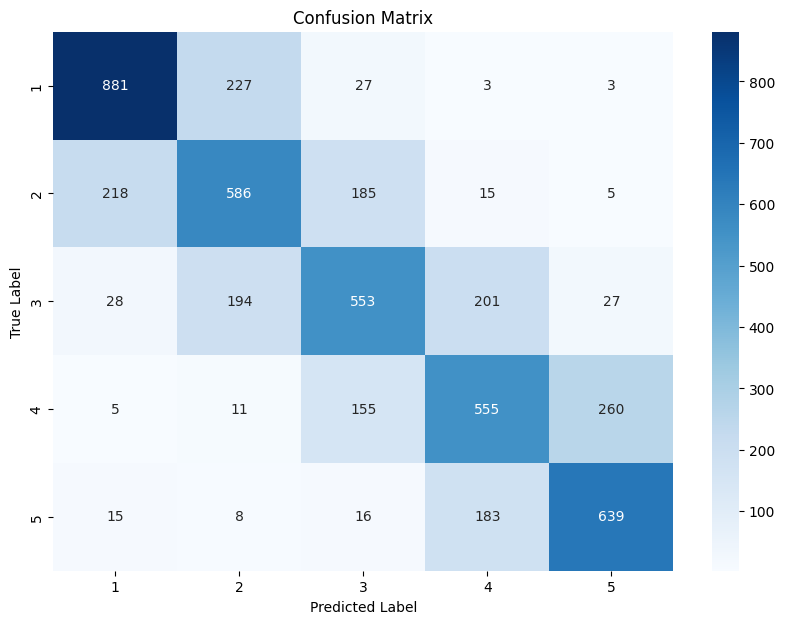

In [19]:
metrics(y_test,y_pred_distilbert_base_uncased_finetuned_yelp_reviews)

As we understand from metrics, it predicts well semantic of the text. What I mean by "semantic" is being positive or negative. However for labels 2,3 and 4 (1,2 and 3 in dataset) it gives similar result to our model. Also F1-Score is same as the accuracy, which indicates precision and recall success are close to each other.

#### jenniferjane/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.0546
* Accuracy: 0.634

In [ ]:
tokenizer_jenniferjane_Bert_Classifier = AutoTokenizer.from_pretrained("jenniferjane/Bert_Classifier")
model_jenniferjane_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("jenniferjane/Bert_Classifier")

In [ ]:
len(x_test)

In [ ]:
y_pred_jenniferjane_Bert_Classifier = predict(x_test, tokenizer_jenniferjane_Bert_Classifier, model_jenniferjane_Bert_Classifier)

In [ ]:
with open('y_pred_jenniferjane_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_jenniferjane_Bert_Classifier, f)

In [4]:
y_pred_jenniferjane_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jenniferjane_Bert_Classifier.json"))

Accuracy: 0.62
F1 Score: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1141
           1       0.55      0.56      0.55      1009
           2       0.54      0.56      0.55      1003
           3       0.55      0.56      0.56       986
           4       0.70      0.66      0.68       861

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.62      0.62      0.62      5000



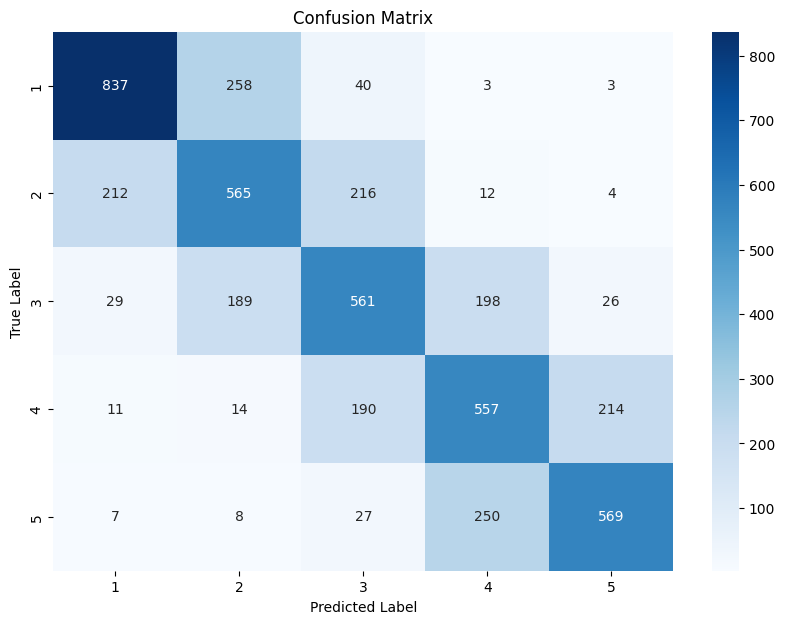

In [21]:
metrics(y_test, y_pred_jenniferjane_Bert_Classifier)

As we see in previous model, accuracy and recall results are very low for labels 2, 3 and 4.

#### jakka/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.9851
* Accuracy: 0.43

In [ ]:
tokenizer_jakka_Bert_Classifier = AutoTokenizer.from_pretrained("jakka/Bert_Classifier")
model_jakka_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("jakka/Bert_Classifier")

In [ ]:
y_pred_jakka_Bert_Classifier = predict(x_test, tokenizer_jakka_Bert_Classifier, model_jakka_Bert_Classifier)

In [ ]:
with open('y_pred_jakka_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_jakka_Bert_Classifier, f)

In [5]:
y_pred_jakka_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jakka_Bert_Classifier.json"))

Accuracy: 0.54
F1 Score: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1141
           1       0.46      0.50      0.48      1009
           2       0.46      0.46      0.46      1003
           3       0.45      0.51      0.48       986
           4       0.65      0.53      0.58       861

    accuracy                           0.54      5000
   macro avg       0.55      0.54      0.54      5000
weighted avg       0.55      0.54      0.55      5000



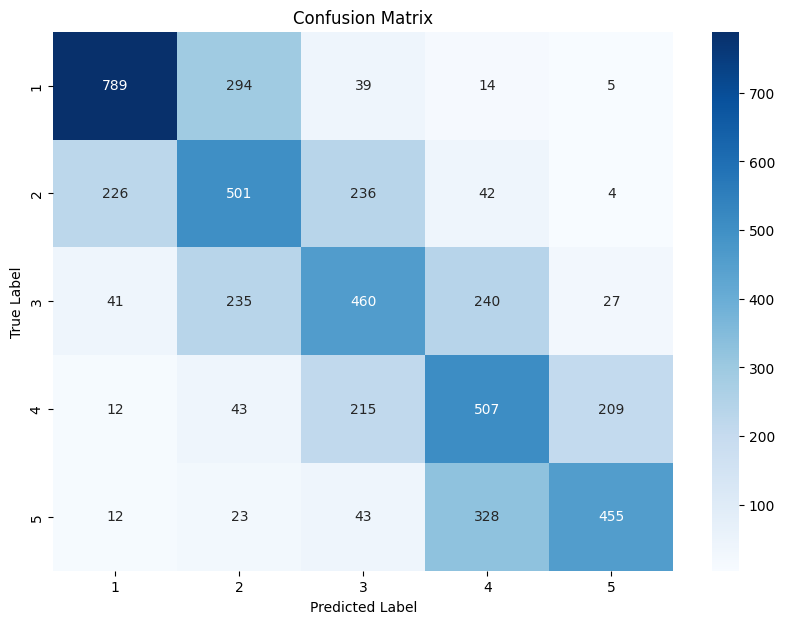

In [23]:
metrics(y_test, y_pred_jakka_Bert_Classifier)

#### BeckyB/Bert_Classifier

This model is a fine-tuned version of bert-base-cased on the yelp_review_full dataset. It achieves the following results on the evaluation set:

* Loss: 1.1067
* Accuracy: 0.5533

In [11]:
tokenizer_BeckyB_Bert_Classifier = AutoTokenizer.from_pretrained("BeckyB/Bert_Classifier")
model_BeckyB_Bert_Classifier = AutoModelForSequenceClassification.from_pretrained("BeckyB/Bert_Classifier")

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
y_pred_BeckyB_Bert_Classifier = predict(x_test, tokenizer_BeckyB_Bert_Classifier, model_BeckyB_Bert_Classifier)

In [13]:
with open('y_pred_BeckyB_Bert_Classifier.json', 'w') as f:
    json.dump(y_pred_BeckyB_Bert_Classifier, f)

In [6]:
y_pred_BeckyB_Bert_Classifier = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_jakka_Bert_Classifier.json"))

Accuracy: 0.56
F1 Score: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1141
           1       0.46      0.48      0.47      1009
           2       0.47      0.42      0.45      1003
           3       0.47      0.50      0.49       986
           4       0.65      0.63      0.64       861

    accuracy                           0.56      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.56      0.56      0.56      5000



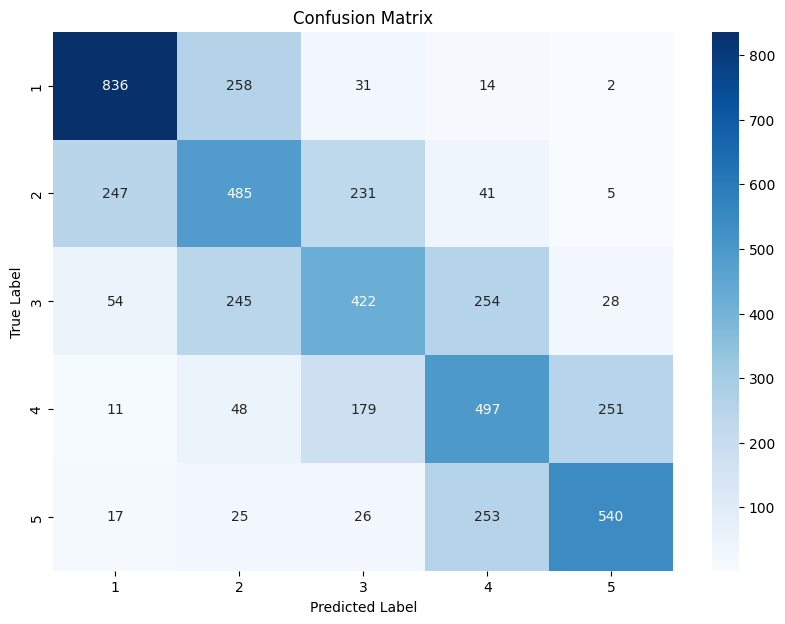

In [14]:
metrics(y_test, y_pred_BeckyB_Bert_Classifier)

#### Shunian/yelp_review_classification

In [15]:
tokenizer_Shunian_yelp_review_classification = AutoTokenizer.from_pretrained("Shunian/yelp_review_classification")
model_Shunian_yelp_review_classification = AutoModelForSequenceClassification.from_pretrained("Shunian/yelp_review_classification")

tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
y_pred_Shunian_yelp_review_classification = predict(x_test, tokenizer_Shunian_yelp_review_classification, model_Shunian_yelp_review_classification)

In [17]:
with open('y_pred_Shunian_yelp_review_classification.json', 'w') as f:
    json.dump(y_pred_Shunian_yelp_review_classification, f)

In [7]:
y_pred_Shunian_yelp_review_classification = json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_Shunian_yelp_review_classification.json"))

Accuracy: 0.68
F1 Score: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1141
           1       0.63      0.61      0.62      1009
           2       0.63      0.63      0.63      1003
           3       0.62      0.58      0.60       986
           4       0.71      0.78      0.74       861

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



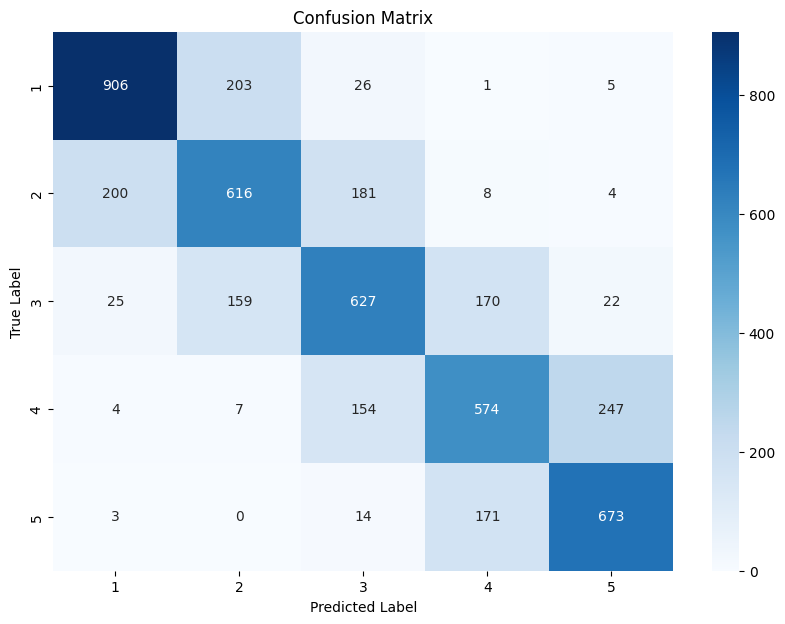

In [24]:
metrics(y_test, y_pred_Shunian_yelp_review_classification)

#### rukshanCodeGen/dummp

In [9]:
tokenizer_rukshanCodeGen_dummp = AutoTokenizer.from_pretrained("rukshanCodeGen/dummp")
model_rukshanCodeGen_dummp = AutoModelForSequenceClassification.from_pretrained("rukshanCodeGen/dummp")

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
y_pred_rukshanCodeGen_dummp = predict(x_test, tokenizer_rukshanCodeGen_dummp, model_rukshanCodeGen_dummp)

In [11]:
with open('y_pred_rukshanCodeGen_dummp.json', 'w') as f:
    json.dump(y_pred_rukshanCodeGen_dummp, f)

In [8]:
y_pred_rukshanCodeGen_dummp = y_pred_rukshanCodeGen_dummp= json.load(open("/kaggle/input/y-pred-hf-models-yelp/y_pred_rukshanCodeGen_dummp.json"))

Accuracy: 0.59
F1 Score: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1141
           1       0.49      0.56      0.52      1009
           2       0.53      0.44      0.48      1003
           3       0.51      0.55      0.53       986
           4       0.67      0.68      0.67       861

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000



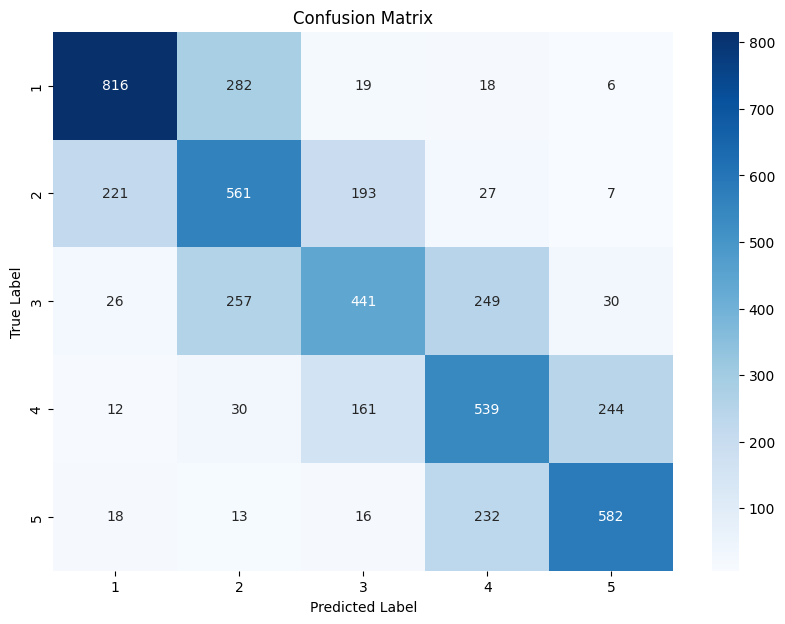

In [15]:
metrics(y_test, y_pred_rukshanCodeGen_dummp)

#### OUR MODEL

Now we will create our tokenizer (BERT) and model. You can see our final model below:

In [98]:
class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

In [52]:
balkon_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
import torch

model_path = '/kaggle/input/balkon-model/attention_model.pth'
model_balkon.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [67]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.1 MB/s eta 0:00:00


In [73]:
import contractions
import re
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))
def preprocess(text):
    # Convert text to UTF-8 encoding
    text = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    text = ' '.join(corrected_slang_words)
    return text

In [74]:
x_test_preprocessed = []
for text in x_test:
    x_test_preprocessed.append(preprocess(text))

In [ ]:
y_pred_balkon = predict(x_test_preprocessed, balkon_tokenizer, model_balkon)

Accuracy: 0.65
F1 Score: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1141
           1       0.66      0.50      0.57      1009
           2       0.62      0.60      0.61      1003
           3       0.59      0.48      0.53       986
           4       0.60      0.87      0.71       861

    accuracy                           0.65      5000
   macro avg       0.64      0.65      0.64      5000
weighted avg       0.65      0.65      0.64      5000



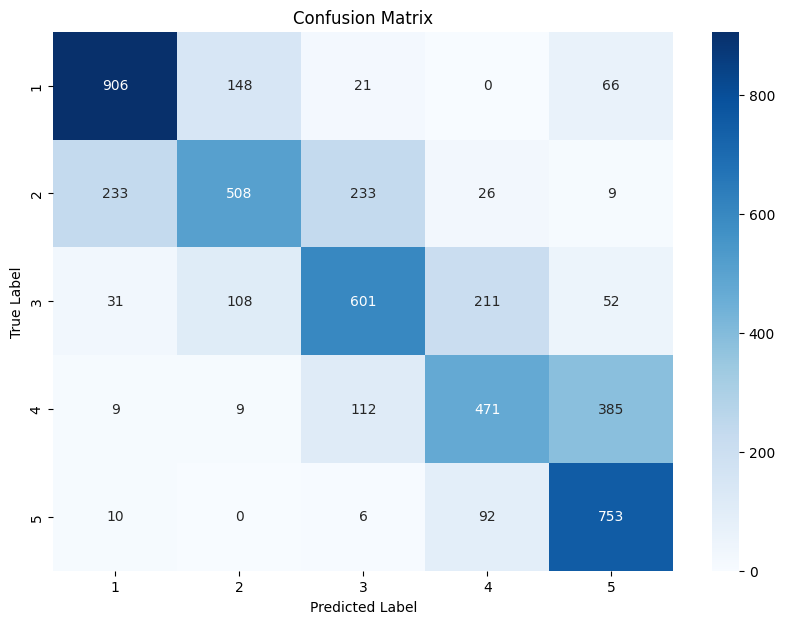

In [78]:
metrics(y_test, y_pred_balkon)

In [62]:
distilbert_base_uncased_finetuned_yelp_reviews_report = classification_report(y_test, y_pred_distilbert_base_uncased_finetuned_yelp_reviews)
jenniferjane_Bert_Classifier_report = classification_report(y_test, y_pred_jenniferjane_Bert_Classifier)
jakka_Bert_Classifier_report = classification_report(y_test, y_pred_jakka_Bert_Classifier)
BeckyB_Bert_Classifier_report = classification_report(y_test, y_pred_BeckyB_Bert_Classifier)
Shunian_yelp_review_classification_report = classification_report(y_test, y_pred_Shunian_yelp_review_classification)
rukshanCodeGen_dummp_report = classification_report(y_test, y_pred_rukshanCodeGen_dummp)
balkon_report = classification_report(y_test, y_pred_balkon)

- Accuracy provides a general measure of the model's performance. It is straightforward to understand and interpret, making it a common first step in evaluating classification models. However, it may not be the best metric when dealing with imbalanced datasets, as it can be misleading if one class dominates the dataset.

- The F1-score balances the trade-off between precision and recall, making it useful for scenarios where both false positives and false negatives are important. It is particularly valuable in imbalanced datasets where accuracy may not adequately reflect the performance of the model on the minority class.

- Precision measures the accuracy of the positive predictions. High precision means that the model is making few false positive errors. This is crucial in applications where false positives are particularly costly, such as spam detection or medical diagnosis.

- Recall measures the ability of the model to identify all relevant instances. High recall is essential in scenarios where missing a positive instance is critical, such as disease screening or fraud detection.

**Deriving Insights from the Metrics**

##### Comparing Models with Accuracy

Why Compare: By comparing the accuracy scores of different models, we can quickly assess which model generally performs better on the dataset.

Insights: Higher accuracy indicates better overall performance, but further analysis is needed if the dataset is imbalanced.

##### Comparing Models with F1-Scores by Class

Why Compare: Comparing F1-scores for each class across different models highlights how well each model handles different classes, especially in multi-class classification problems.

Insights: Variations in F1-scores across classes can indicate which classes are challenging for the models. A model with consistently high F1-scores across all classes is preferable.

##### Analyzing Precision and Recall by Class

Why Compare: Examining precision and recall for each class allows us to understand the trade-offs each model makes between precision and recall.

Insights: High precision with low recall may indicate that the model is conservative in its positive predictions, avoiding false positives but missing some true positives. Conversely, high recall with low precision suggests the model captures most of the positive instances but at the cost of many false positives.

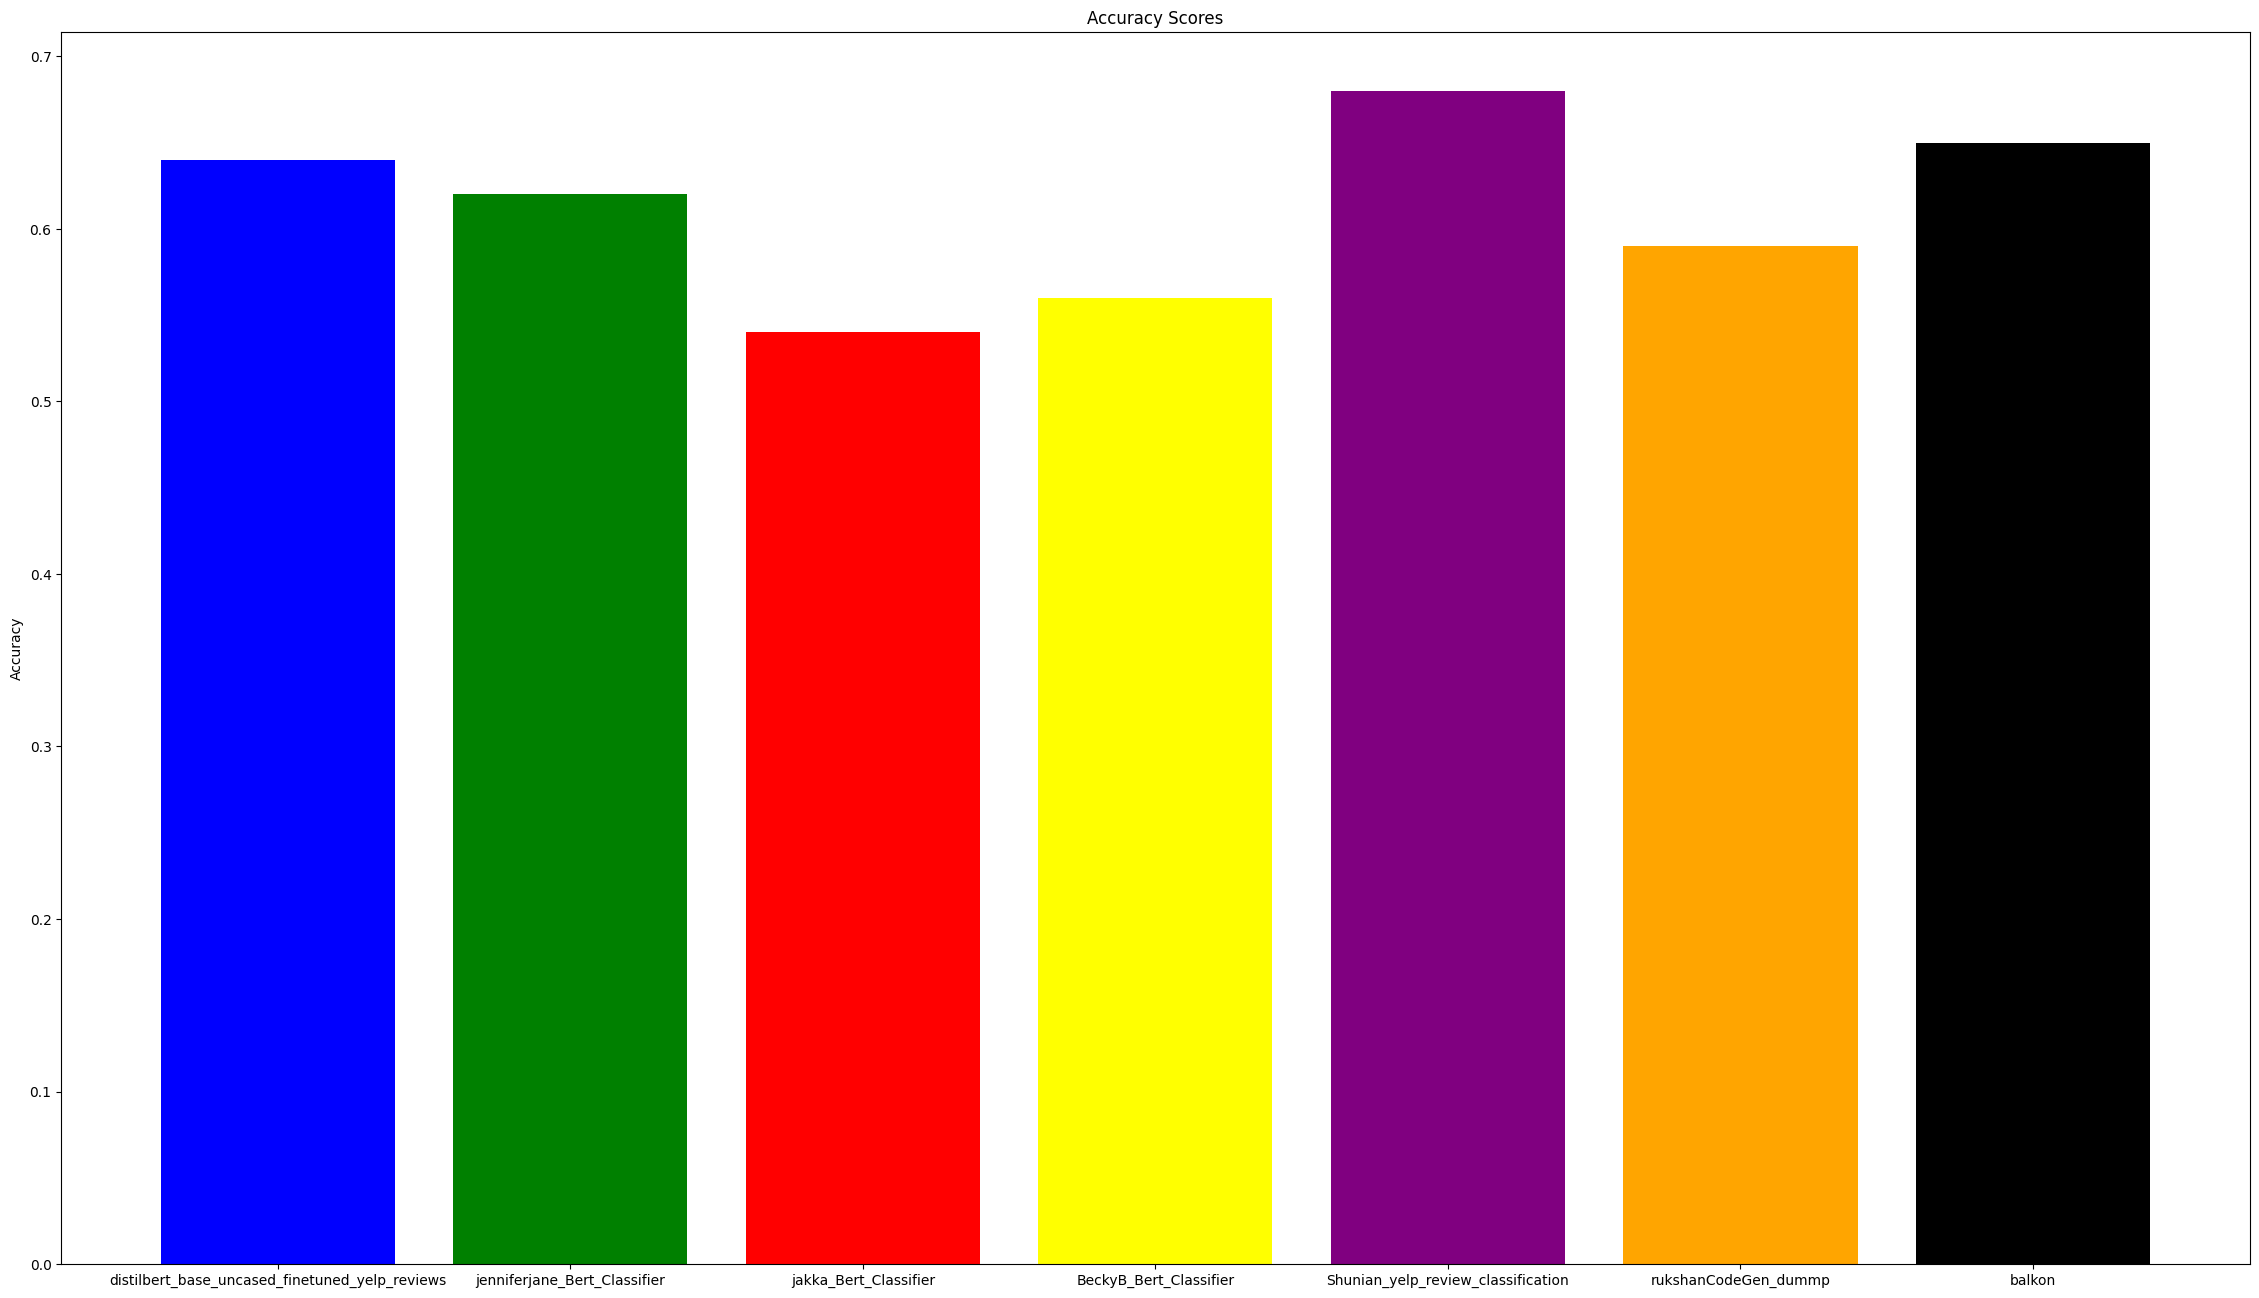

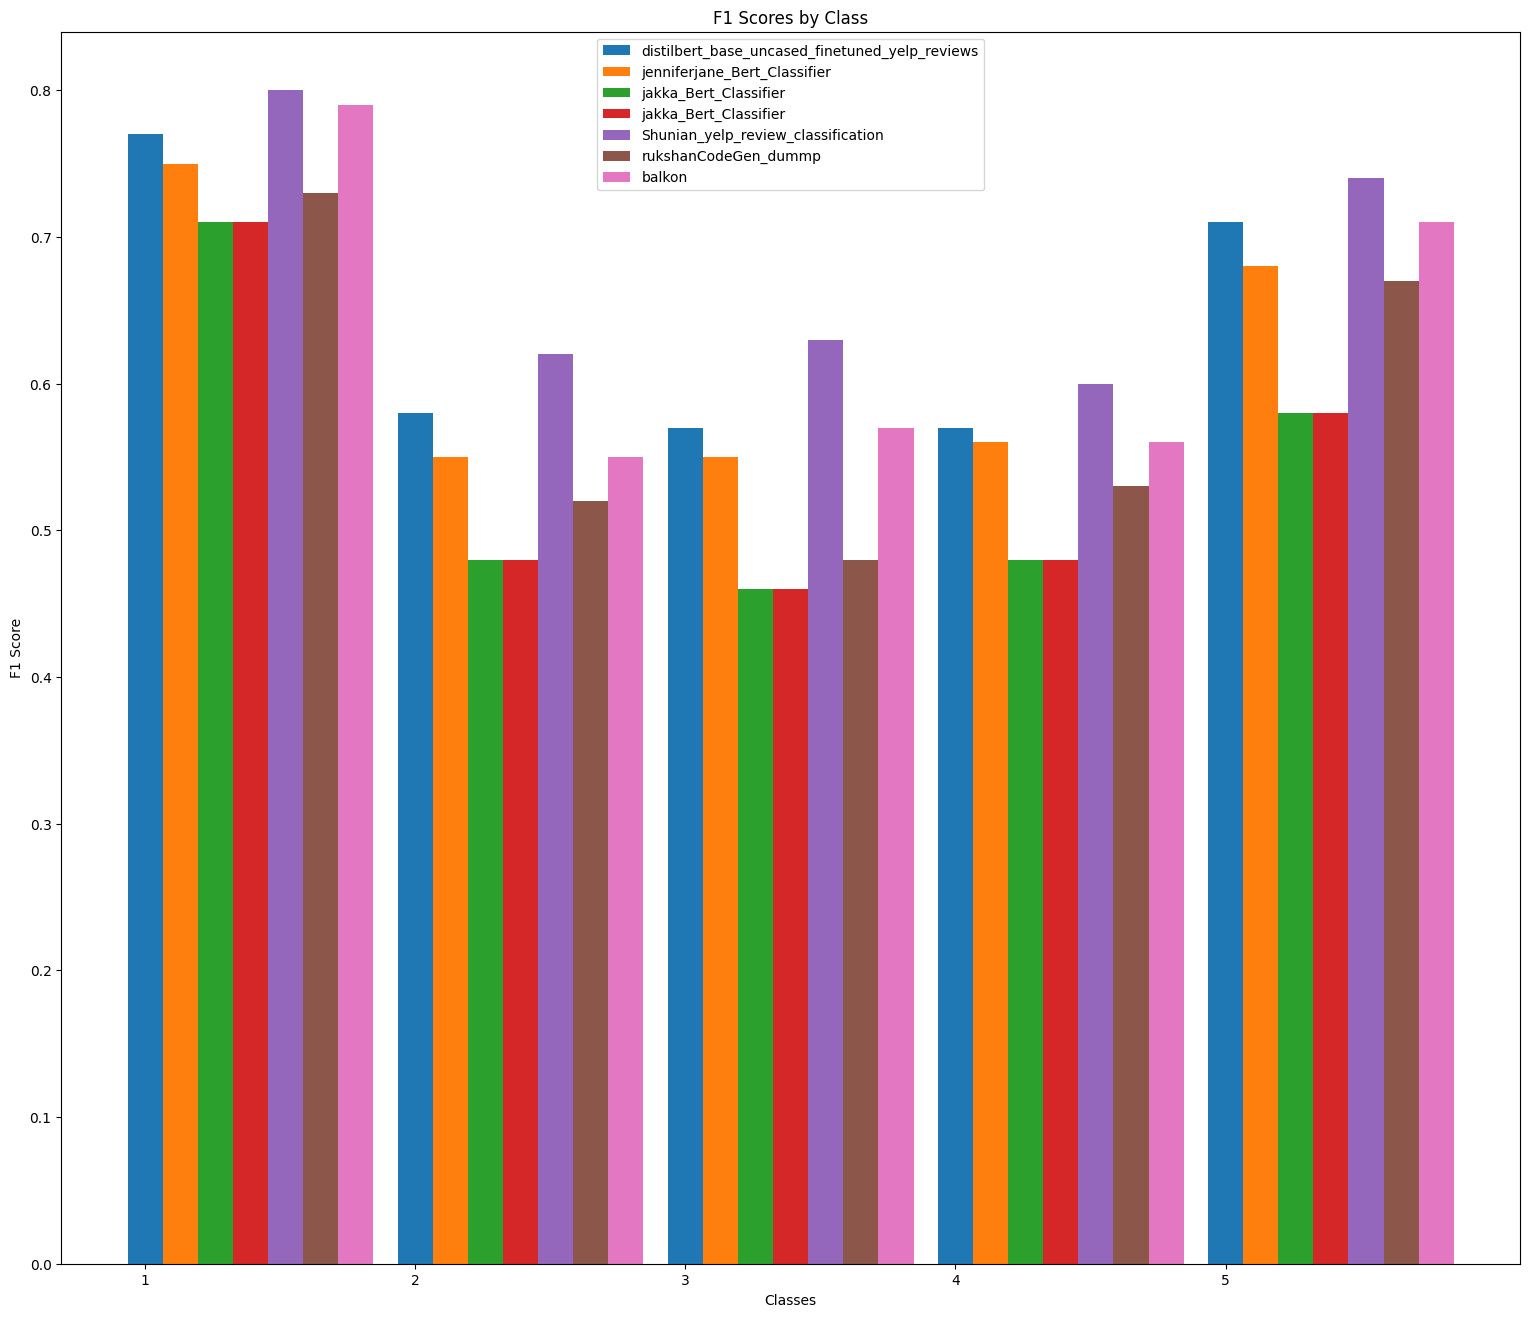

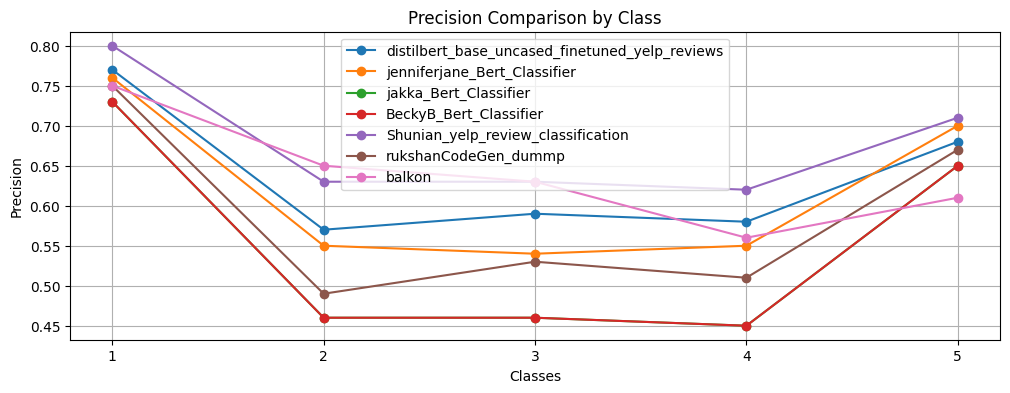

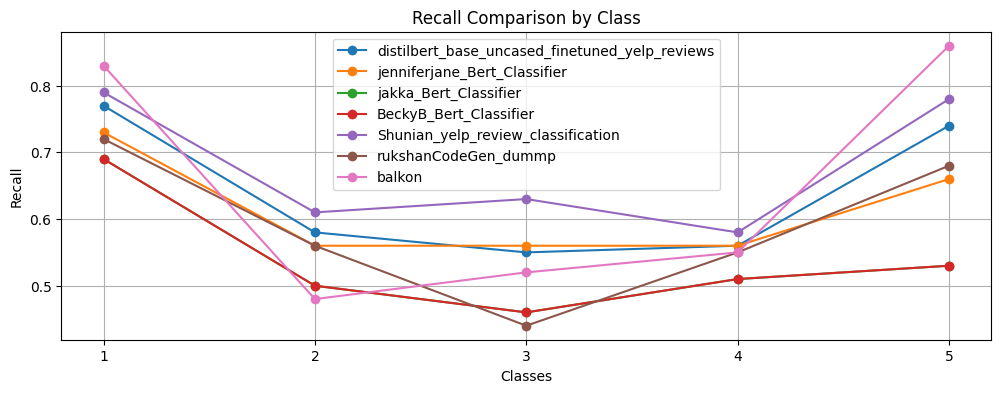

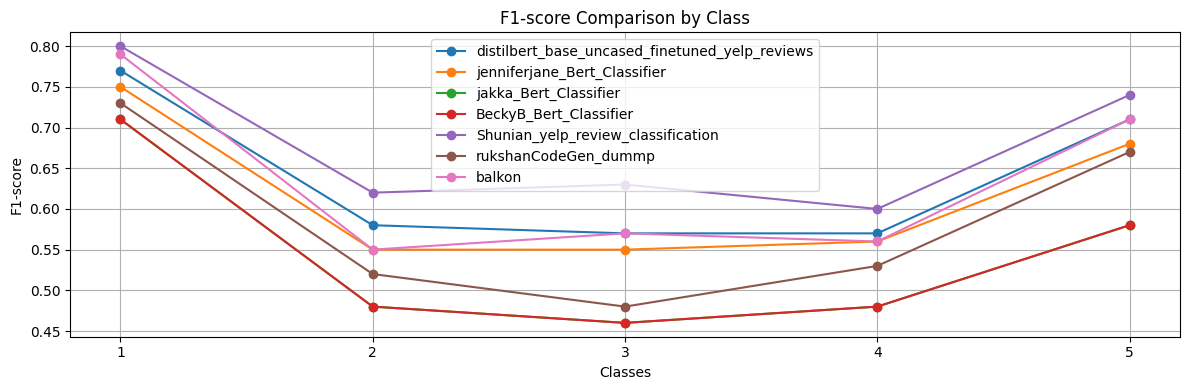

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for three models
models = ['distilbert_base_uncased_finetuned_yelp_reviews', 'jenniferjane_Bert_Classifier', 'jakka_Bert_Classifier', 'BeckyB_Bert_Classifier', 'Shunian_yelp_review_classification', 'rukshanCodeGen_dummp', 'balkon']
accuracy_scores = [0.64, 0.62, 0.54, 0.56, 0.68, 0.59, 0.65]

# F1-scores for each class for each model
f1_scores_model1 = [float(r.split()[3]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]] ##f1-score
f1_scores_model2 = [float(r.split()[3]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model3 = [float(r.split()[3]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model4 = [float(r.split()[3]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
f1_scores_model5 = [float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-score
f1_scores_model6 = [float(r.split()[3]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]] ##f1-score
f1_scores_model7 = [float(r.split()[3]) for r in balkon_report.split('\n')[2:7]] ##f1-score
# Classification report metrics for each c[float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-scorelass (precision, recall, f1-score) for one model
# Assuming we have the same structure for Model 1, Model 2, and Model 3
classification_reports = {
    'distilbert_base_uncased_finetuned_yelp_reviews': {
        'precision': [float(r.split()[1]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]], ##recall
        'f1-score': [float(r.split()[3]) for r in distilbert_base_uncased_finetuned_yelp_reviews_report.split('\n')[2:7]] ##f1-score
    },
    'jenniferjane_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]], ##recall
        'f1-score': [float(r.split()[3]) for r in jenniferjane_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'jakka_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in jakka_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'BeckyB_Bert_Classifier': {
        'precision': [float(r.split()[1]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in BeckyB_Bert_Classifier_report.split('\n')[2:7]] ##f1-score
    },
    'Shunian_yelp_review_classification': {
        'precision': [float(r.split()[1]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in Shunian_yelp_review_classification_report.split('\n')[2:7]] ##f1-score
    },
    'rukshanCodeGen_dummp': {
        'precision': [float(r.split()[1]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in rukshanCodeGen_dummp_report.split('\n')[2:7]] ##f1-score   
    },
    'balkon': {
        'precision': [float(r.split()[1]) for r in balkon_report.split('\n')[2:7]], ##precision
        'recall': [float(r.split()[2]) for r in balkon_report.split('\n')[2:7]],##recall
        'f1-score': [float(r.split()[3]) for r in balkon_report.split('\n')[2:7]] ##f1-score         
    }
}

# Plot accuracy scores
plt.figure(figsize=(96, 16))
plt.subplot(1, 3, 1)
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'black'])
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')

# Plot F1-scores for each class
classes = ['1', '2', '3', '4', '5']
x = np.arange(len(classes))

plt.figure(figsize=(64, 16))
plt.subplot(1, 3, 2)
width = 0.13
plt.bar(x, f1_scores_model1, width, label='distilbert_base_uncased_finetuned_yelp_reviews')
plt.bar(x + (width), f1_scores_model2, width, label='jenniferjane_Bert_Classifier')
plt.bar(x + (2*width), f1_scores_model3, width, label='jakka_Bert_Classifier')
plt.bar(x + (3*width), f1_scores_model4, width, label='jakka_Bert_Classifier')
plt.bar(x + (4*width), f1_scores_model5, width, label='Shunian_yelp_review_classification')
plt.bar(x + (5*width), f1_scores_model6, width, label='rukshanCodeGen_dummp')
plt.bar(x + (6*width), f1_scores_model7, width, label='balkon')

plt.title('F1 Scores by Class')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(x, classes)
plt.legend()

# Plot precision, recall, f1-score for each class for one model
metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    plt.figure(figsize=(12, 4))
    plt.title(f'{metric.capitalize()} Comparison by Class')
    for model, data in classification_reports.items():
        plt.plot(classes, data[metric], marker='o', label=model)
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


But we made this experiment with 5000 samples. Now let's compare the results of the all test dataset.

In [80]:
# Sample data for three models
models = ['distilbert_base_uncased_finetuned_yelp_reviews', 'jenniferjane_Bert_Classifier', 'jakka_Bert_Classifier', 'BeckyB_Bert_Classifier', 'Shunian_yelp_review_classification', 'rukshanCodeGen_dummp', 'balkon']
accuracy_scores = [0.6425, 0.634, 0.43, 0.5533, 0.6852, 0.638, 0.6890]

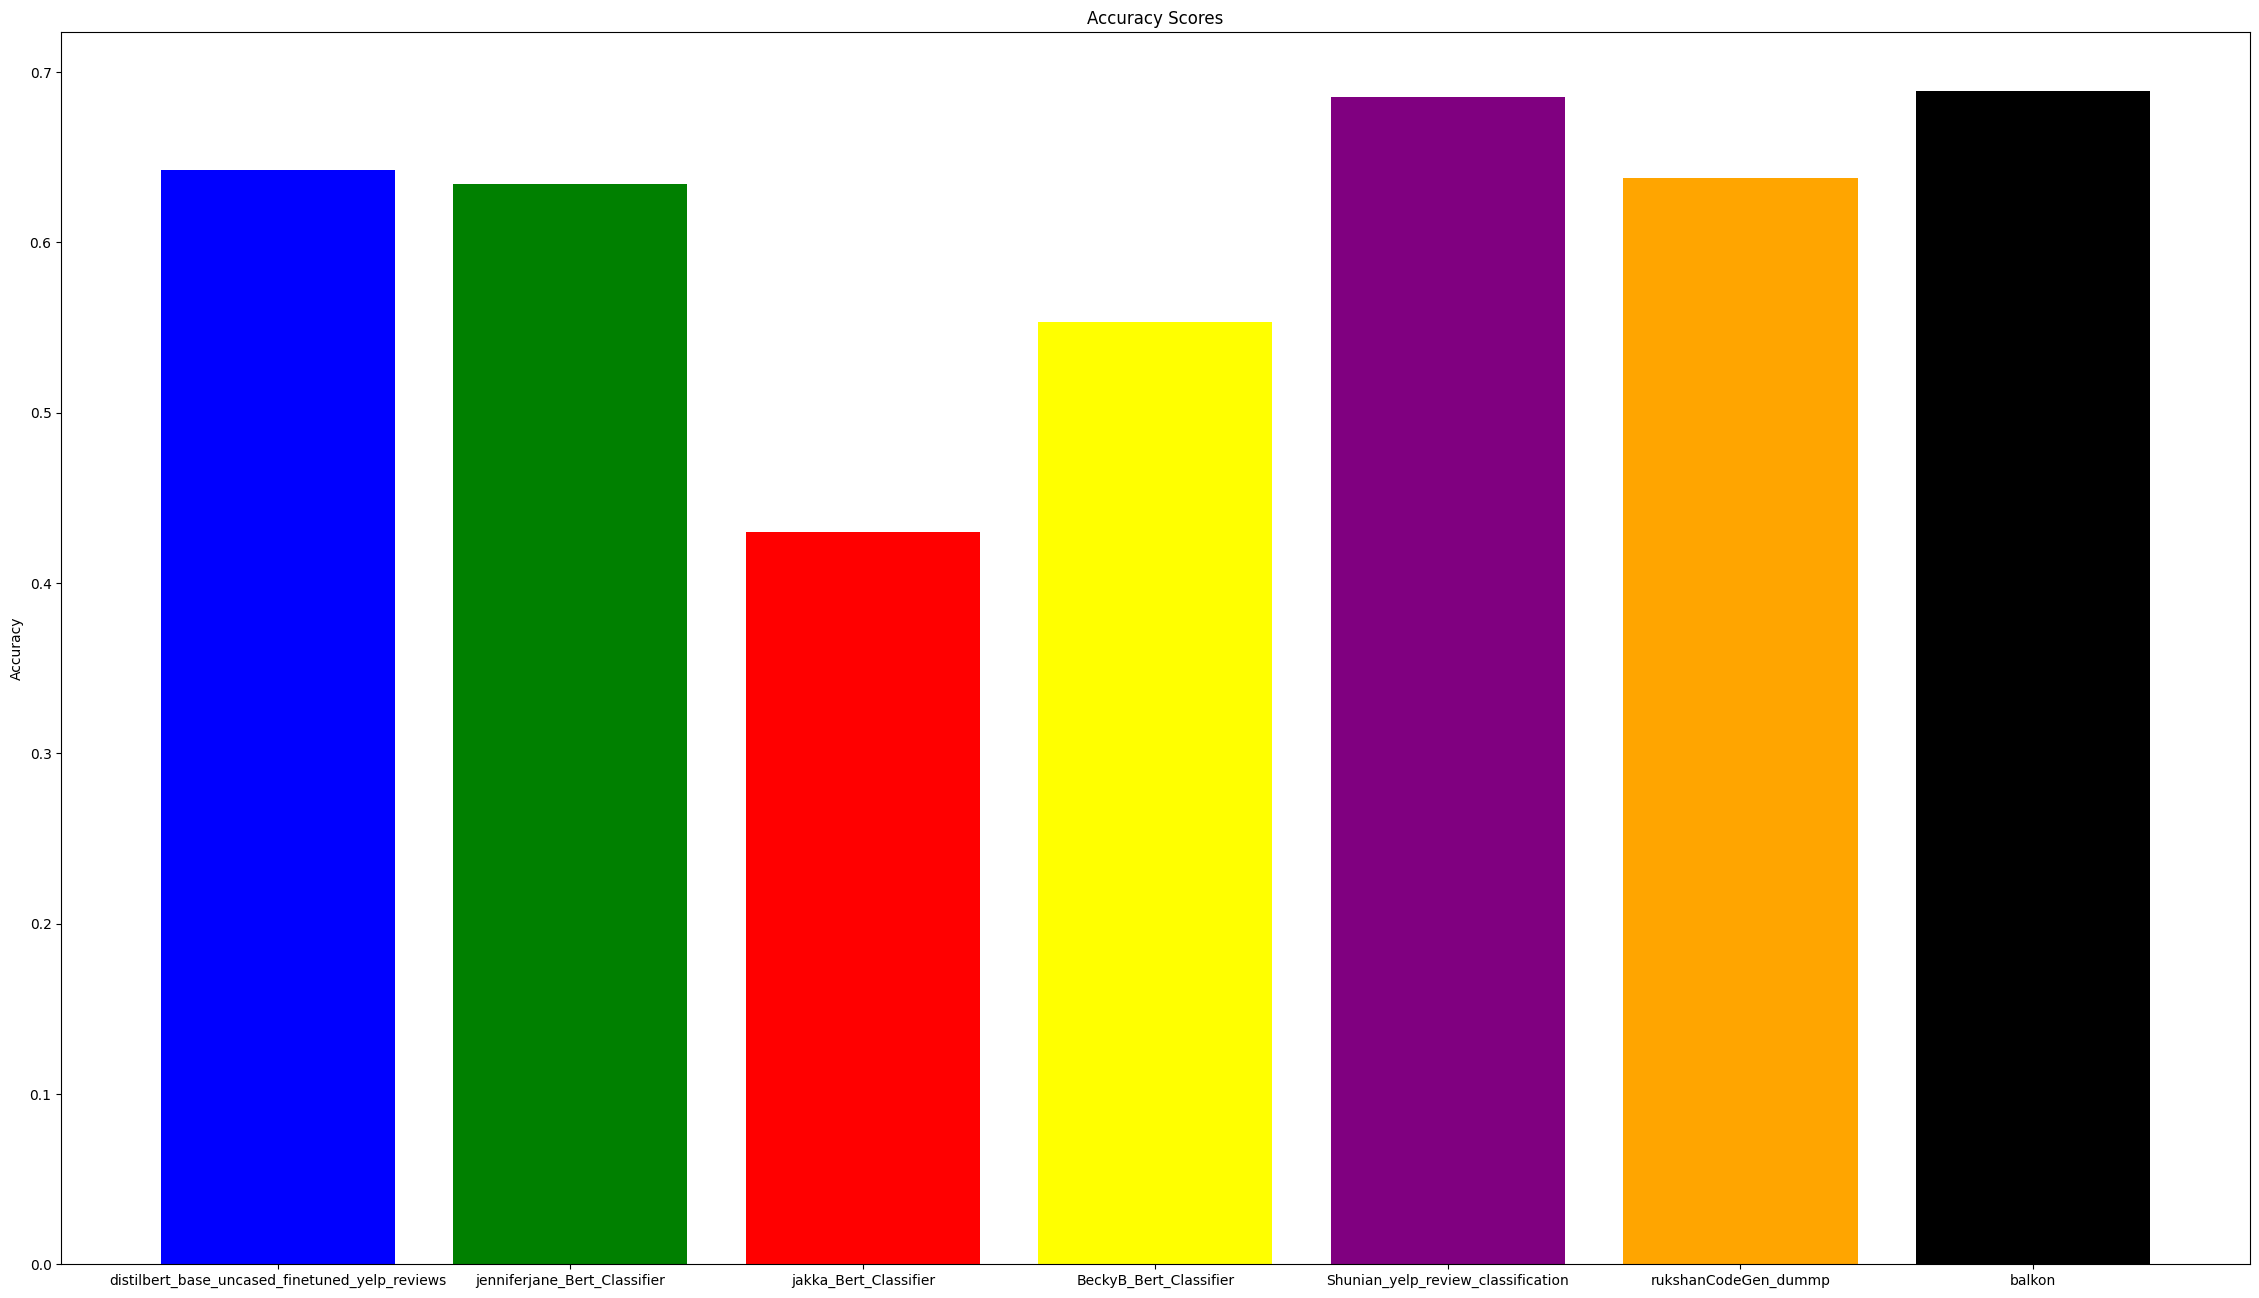

In [81]:
# Plot accuracy scores
plt.figure(figsize=(96, 16))
plt.subplot(1, 3, 1)
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'black'])
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

* Our model gives better results than the models in the huggingface. 
* Shunian_yelp_review_classification is the most succesful model in the HF, however our model's accuracy and f1-score is better than it (f1-score is very similar because test set is not unbalanced)
* Our model can give better results for best and worst reviews. The models we compare achieve better precision and recall for these labels.

### Possible Extensions

We have performed multiclass classification so far. But as you can see from the source from internet and huggingface, binary classification is also popular for this dataset.

##### Sentiment Analysis
**Data Preparation**

Labeling: Assign labels to the reviews. For binary sentiment analysis:

* Positive reviews (4 and 5 stars) -> Label as 1.
* Negative reviews (1 and 2 stars) -> Label as 0.
* Optionally, exclude 3-star reviews for a clear binary distinction.

Text Preprocessing:
* Tokenization
* Slang removal
* Vectorization (BERT embeddings)

**Model Building**

Feature Extraction:

* Convert reviews into numerical representations using methods like Bag of Words (BoW), TF-IDF, or embeddings from pre-trained language models.
* We use our neural network architecture for this task.

Model Selection:
* EnhancedBertClassifier (look the above code)

Training and Evaluation:

* Split the data into training and test sets.
* Train the model on the training set.
* Evaluate the model on the test set using metrics like accuracy, precision, recall, F1-score, and ROC-AUC.


In [99]:
# Load pre-trained BERT model
config = BertConfig.from_pretrained("bert-base-uncased")
model_balkon_binary = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Define the new classifier layers
classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 256),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Dropout(config.hidden_dropout_prob),
    nn.Linear(64, 2)  # Change output to 2 for binary classification
)

# Replace the classifier of the pre-trained model
model_balkon_binary.classifier = classifier

# Update the number of labels in the config
model_balkon_binary.config.num_labels = 2  # Change to 2 for binary classification
model_balkon_binary.num_labels = 2  # Change to 2 for binary classification

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
import torch

model_path = '/kaggle/input/balkon-model/binary_model.pth'
model_balkon_binary.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [101]:
x_test_all = test_dataset['text']
y_test_all = test_dataset['label']

In [ ]:
y_test_all

In [116]:
x_test_all_preprocessed = []
y_test_all_new = []
for i,text in enumerate(x_test_all):
    if y_test_all[i] == 2:
        continue
    x_test_all_preprocessed.append(preprocess(text))
    if y_test_all[i] == 0 or y_test_all[i] == 1:
        y_test_all_new.append(0)
    if y_test_all[i] == 3 or y_test_all[i] == 4:
        y_test_all_new.append(1)

In [117]:
len(y_test_all_new)

40000

In [ ]:
y_binary_pred_balkon = predict(x_test_all_preprocessed[:5000], balkon_tokenizer, model_balkon_binary)

Accuracy: 0.96
F1 Score: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2681
           1       0.96      0.96      0.96      2319

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



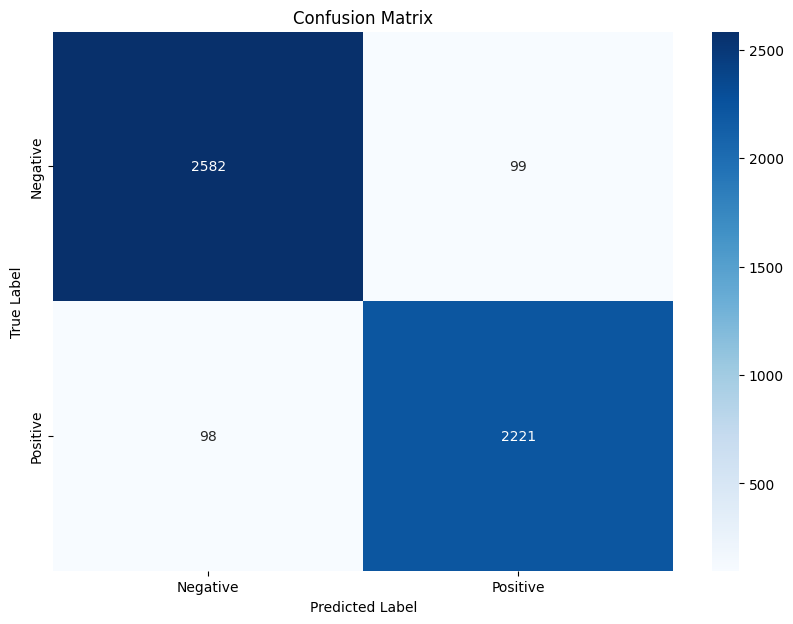

In [123]:
metrics(y_test_all_new[:5000], y_binary_pred_balkon,  binary=True)